Importing Neccessary Libraries

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import random
import itertools
import os
from tabulate import tabulate

import matplotlib.image as mpImg 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn import datasets
from sklearn.mixture import GaussianMixture

from google.colab import drive


In [21]:
random.seed(42)

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#  <font color=slateblue>Problem 2</font> #

Text(0, 0.5, 'p(D|θ)')

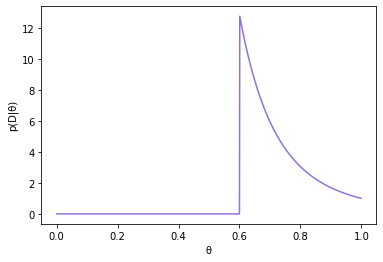

In [4]:
theta = np.arange(0,1,0.001)
plt.plot(theta, np.array([[1/(theta[i]**5) if theta[i]>0.6 else 0]for i in range(1000)]), color='mediumpurple')
plt.xlabel('\u03B8')
plt.ylabel('p(D|\u03B8)')

#  <font color=slateblue>Problem 7</font> #

###  <font color=slateblue>GMM for All Data</font> ###

Reading Images

In [5]:
folderPath = '/content/gdrive/My Drive/Colab Notebooks/HW/3/HW3_Q7_Dataset/Q6_Dataset/Images'
images = [mpImg.imread(os.path.join(folderPath, fileName)) for fileName in  os.listdir(folderPath)]

Finding Average RGB (Removing G)

In [6]:
numImages = len(images)
avgRB = np.zeros([numImages,2])

for i in range(0,numImages):
  avgRB[i,0] = np.average(np.average(images[i], axis=0), axis=0)[0]
  avgRB[i,1] = np.average(np.average(images[i], axis=0), axis=0)[2]

###  <font color=slateblue>Part A</font> ###

Employing GMM (k=2)

In [7]:
myModel = GaussianMixture(2, covariance_type='full', random_state=0).fit(avgRB)

In [8]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))
    
plotTable({1:["Mean", "Covariance"], 
                2:[(myModel.means_[0]), (myModel.covariances_[0])],
                3:[(myModel.means_[1]), (myModel.covariances_[1])]},
                ['', 'Component 1', 'Component 2'], 3)


╒════════════╤═══════════════════════════════╤═══════════════════════════════╕
│            │          Component 1          │          Component 2          │
╞════════════╪═══════════════════════════════╪═══════════════════════════════╡
│    Mean    │  [106.81314379  91.7794563 ]  │   [73.22719697 62.12078031]   │
├────────────┼───────────────────────────────┼───────────────────────────────┤
│ Covariance │ [[750.57013865 268.08102344]  │ [[400.13701231 131.96282572]  │
│            │  [268.08102344 973.98691004]] │  [131.96282572 308.07777157]] │
╘════════════╧═══════════════════════════════╧═══════════════════════════════╛


Plot Ellipsoids

In [9]:
def plotEllipsoids(data, predLabels, means, covariances, index, title, colorPalette):
  fig = plt.figure(figsize=(8, 15))
  splot = plt.subplot(2, 1, 1 + index)

  for i, (mean, covar, color) in enumerate(zip(means, covariances, colorPalette)):
    v, w = LA.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / LA.norm(w[0])

    if not np.any(predLabels == i):
      continue
    plt.scatter(data[predLabels == i, 0], data[predLabels == i, 1], 10, color=color)

        
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi 
    ell = Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.4)
    splot.add_artist(ell)

  plt.xticks(())
  plt.yticks(())
  plt.title(title)

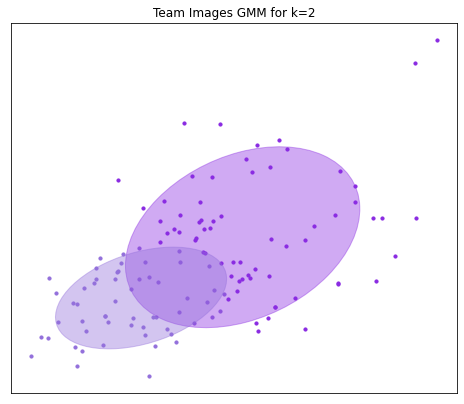

In [10]:
colorPalette = itertools.cycle(['blueviolet', 'mediumpurple'])
plotEllipsoids(avgRB, myModel.predict(avgRB), myModel.means_, myModel.covariances_, 0,
             'Team Images GMM for k=2', colorPalette)

Plot Contours

In [11]:
def plotCont(mid, cov):
    ax = plt.gca()
    
    if cov.shape == (2, 2):
        U, S, Vt = LA.svd(cov)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(S)
    else:
        angle = 0
        width, height = 2 * np.sqrt(cov)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(mid, nsig * width, nsig * height, 
                             angle, alpha=0.1, color='slateblue'))

def plotDataAndCont(data, predLabels, mu, sigma, order, colorPalette, title):
  fig = plt.figure(figsize=(8,6))

  for i in range(order):
    plotCont(mu[i], sigma[i])

  for i, (_, color) in enumerate(zip(data, colorPalette)):
    plt.scatter(data[predLabels == i, 0], data[predLabels == i, 1], 20, 
                color=color)

  plt.xticks(())
  plt.yticks(())
  plt.title(title)
  plt.show()

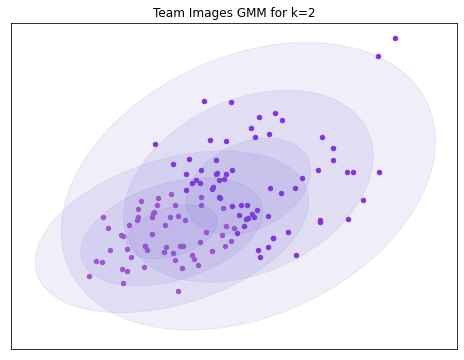

In [12]:
colorPalette = itertools.cycle(['blueviolet', 'mediumorchid'])
plotDataAndCont(avgRB, myModel.predict(avgRB), myModel.means_, 
                myModel.covariances_, 2, colorPalette, 'Team Images GMM for k=2')

###  <font color=slateblue>Part B</font> ###

Plot BIC and AIC

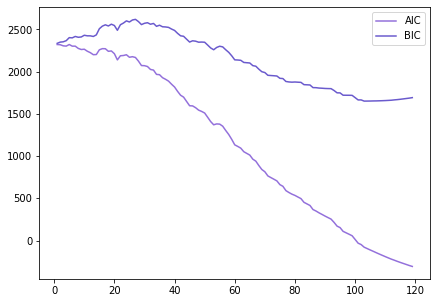

In [19]:
n_comp = np.arange(1,120)
models = [GaussianMixture(n, covariance_type='full',
                          random_state=0).fit(avgRB) for n in n_comp]

fig = plt.figure(figsize=(7,5))
plt.plot(n_comp, [model.aic(avgRB) for model in models],
         label="AIC", color='mediumpurple')
plt.plot(n_comp, [model.bic(avgRB) for model in models], 
         label="BIC", color='slateblue')
plt.legend(loc='best')
plt.show()

Plot Ellipsoids and Contours for Various Values

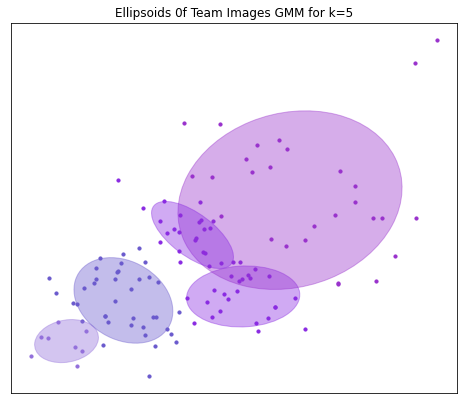

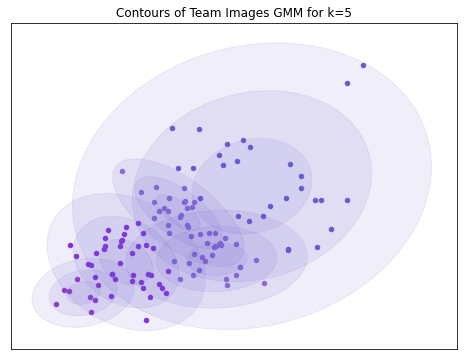

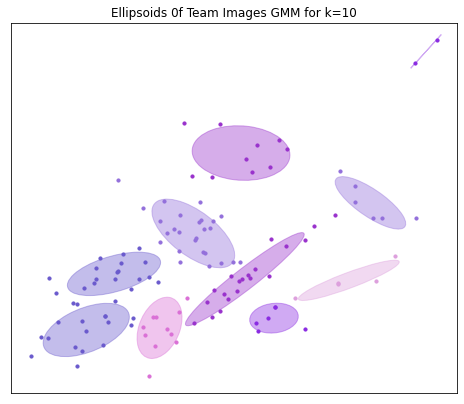

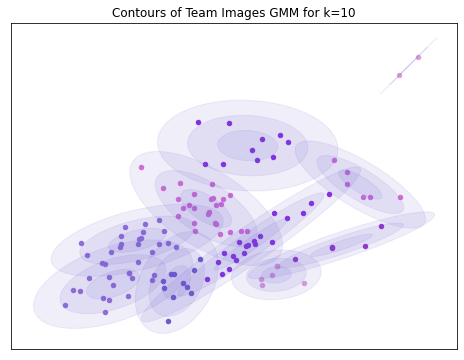

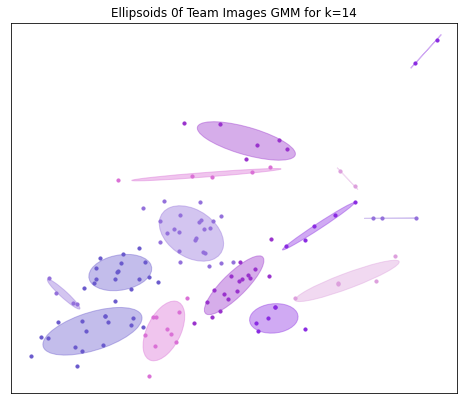

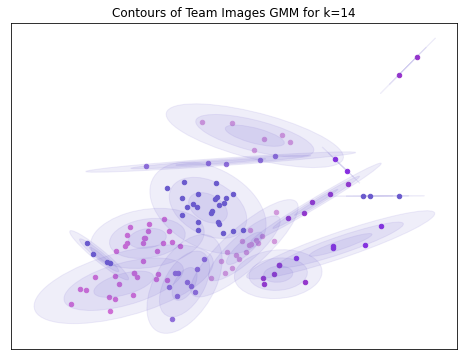

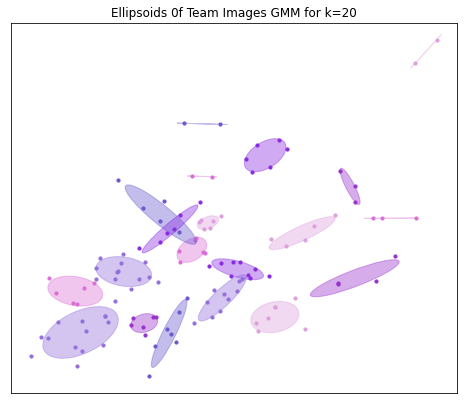

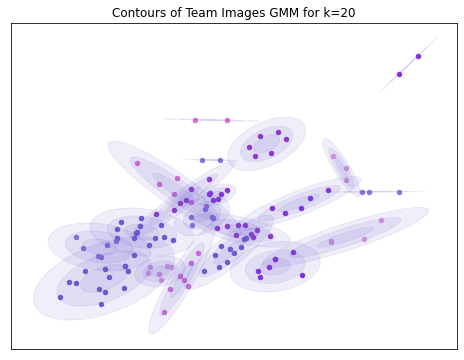

In [14]:
#k = 5
myModel = GaussianMixture(5, covariance_type='full', random_state=0).fit(avgRB)

colorPalette = itertools.cycle(['blueviolet', 'mediumpurple', 'darkorchid', 
                                'slateblue'])
plotEllipsoids(avgRB, myModel.predict(avgRB), myModel.means_, myModel.covariances_, 0,
             'Ellipsoids 0f Team Images GMM for k=5', colorPalette)
plotDataAndCont(avgRB, myModel.predict(avgRB), myModel.means_, 
                myModel.covariances_, 5, colorPalette, 'Contours of Team Images GMM for k=5')

#k = 10
myModel = GaussianMixture(10, covariance_type='full', random_state=0).fit(avgRB)

colorPalette = itertools.cycle(['blueviolet', 'mediumpurple', 'darkorchid', 
                                'slateblue', 'plum', 'orchid'])
plotEllipsoids(avgRB, myModel.predict(avgRB), myModel.means_, myModel.covariances_, 0,
             'Ellipsoids 0f Team Images GMM for k=10', colorPalette)
plotDataAndCont(avgRB, myModel.predict(avgRB), myModel.means_, 
                myModel.covariances_, 10, colorPalette, 'Contours of Team Images GMM for k=10')


#k = 14
myModel = GaussianMixture(14, covariance_type='full', random_state=0).fit(avgRB)

plotEllipsoids(avgRB, myModel.predict(avgRB), myModel.means_, myModel.covariances_, 0,
             'Ellipsoids 0f Team Images GMM for k=14', colorPalette)
plotDataAndCont(avgRB, myModel.predict(avgRB), myModel.means_, 
                myModel.covariances_, 14, colorPalette, 'Contours of Team Images GMM for k=14')

#k = 20
myModel = GaussianMixture(20, covariance_type='full', random_state=0).fit(avgRB)

plotEllipsoids(avgRB, myModel.predict(avgRB), myModel.means_, myModel.covariances_, 0,
             'Ellipsoids 0f Team Images GMM for k=20', colorPalette)
plotDataAndCont(avgRB, myModel.predict(avgRB), myModel.means_, 
                myModel.covariances_, 20, colorPalette, 'Contours of Team Images GMM for k=20')

###  <font color=slateblue>GMM for Each Class</font> ###

Reading Images

In [23]:
folderPath = '/content/gdrive/My Drive/Colab Notebooks/HW/3/HW3_Q7_Dataset/Q6_Dataset/Images'
images = [mpImg.imread(os.path.join(folderPath, fileName)) for fileName in  os.listdir(folderPath)]
imageNames = [fileName.replace('.jpg', '') for fileName in  os.listdir(folderPath)]

In [24]:
ManU = 0
Chelsea = 1
numImageNames = len(imageNames)
labels = [Chelsea if imageNames[i][0] == 'c' or imageNames[i] == 'index' else ManU for i in range(0, numImageNames)]

Finding Average RGB (Removing G)

In [25]:
numImages = len(images)
avgRB = np.zeros([numImages,2])

for i in range(0,numImages):
  avgRB[i,0] = np.average(np.average(images[i], axis=0), axis=0)[0]
  avgRB[i,1] = np.average(np.average(images[i], axis=0), axis=0)[2]

In [26]:
manUImgAvg = [avgRB[i,:] for i in range(0,numImages) if labels[i]==ManU]
chelseaImgAvg = [avgRB[i,:] for i in range(0,numImages) if labels[i]==Chelsea]

###  <font color=slateblue>Part A</font> ###

Employing GMM (k=2)

In [27]:
myModelManU = GaussianMixture(2, covariance_type='full', random_state=0).fit(manUImgAvg)
myModelChelsea = GaussianMixture(2, covariance_type='full', random_state=0).fit(chelseaImgAvg)

In [28]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))
    
plotTable({1:["Mean", "Covariance"], 
                2:[(myModelManU.means_[0]), (myModelManU.covariances_[0])],
                3:[(myModelManU.means_[1]), (myModelManU.covariances_[1])]},
                ['Manchester United', 'Component 1', 'Component 2'], 3)

plotTable({1:["Mean", "Covariance"], 
                2:[(myModelChelsea.means_[0]), (myModelChelsea.covariances_[0])],
                3:[(myModelChelsea.means_[1]), (myModelChelsea.covariances_[1])]},
                ['Chelsea', 'Component 1', 'Component 2'], 3)


╒═════════════════════╤═══════════════════════════════╤═══════════════════════════════╕
│  Manchester United  │          Component 1          │          Component 2          │
╞═════════════════════╪═══════════════════════════════╪═══════════════════════════════╡
│        Mean         │   [97.66912718 61.47298717]   │  [147.967202   106.51672625]  │
├─────────────────────┼───────────────────────────────┼───────────────────────────────┤
│     Covariance      │ [[632.17809487 302.09403659]  │ [[ 60.9736979  -62.82591814]  │
│                     │  [302.09403659 323.48638795]] │  [-62.82591814 131.3730454 ]] │
╘═════════════════════╧═══════════════════════════════╧═══════════════════════════════╛
╒════════════╤═════════════════════════════════╤═══════════════════════════════╕
│  Chelsea   │           Component 1           │          Component 2          │
╞════════════╪═════════════════════════════════╪═══════════════════════════════╡
│    Mean    │   [102.86599546 111.80320728]   │   [7

Plot Ellipsoids

In [29]:
def plotEllipsoids(data, predLabels, means, covariances, index, title, colorPalette):
  fig = plt.figure(figsize=(8, 15))
  splot = plt.subplot(2, 1, 1 + index)

  for i, (mean, covar, color) in enumerate(zip(means, covariances, colorPalette)):
    v, w = LA.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / LA.norm(w[0])

    if not np.any(predLabels == i):
      continue
    plt.scatter(data[predLabels == i, 0], data[predLabels == i, 1], 10, color=color)

        
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi 
    ell = Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.4)
    splot.add_artist(ell)

  plt.xticks(())
  plt.yticks(())
  plt.title(title)

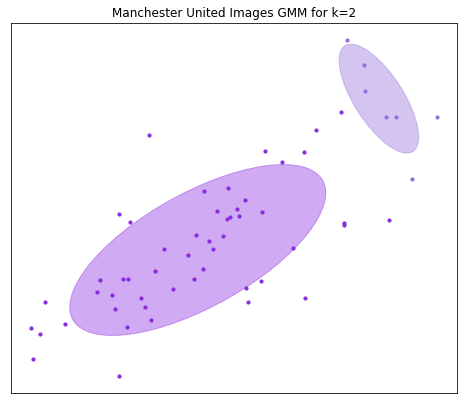

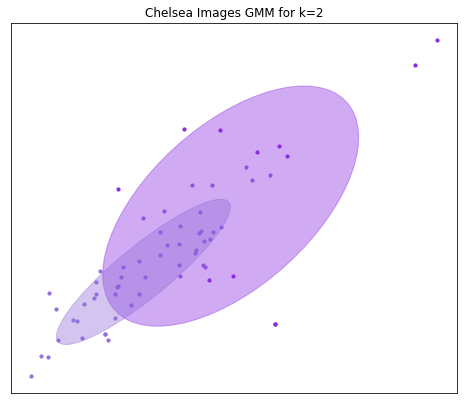

In [30]:
colorPalette = itertools.cycle(['blueviolet', 'mediumpurple'])
plotEllipsoids(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), myModelManU.means_, myModelManU.covariances_, 0,
             'Manchester United Images GMM for k=2', colorPalette)
plotEllipsoids(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), myModelChelsea.means_, myModelChelsea.covariances_, 0,
             'Chelsea Images GMM for k=2', colorPalette)

Plot Contours

In [31]:
def plotCont(mid, cov):
    ax = plt.gca()
    
    if cov.shape == (2, 2):
        U, S, Vt = LA.svd(cov)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(S)
    else:
        angle = 0
        width, height = 2 * np.sqrt(cov)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(mid, nsig * width, nsig * height, 
                             angle, alpha=0.1, color='slateblue'))

def plotDataAndCont(data, predLabels, mu, sigma, order, colorPalette, title):
  fig = plt.figure(figsize=(8,6))

  for i in range(order):
    plotCont(mu[i], sigma[i])

  for i, (_, color) in enumerate(zip(data, colorPalette)):
    plt.scatter(data[predLabels == i, 0], data[predLabels == i, 1], 20, 
                color=color)

  plt.xticks(())
  plt.yticks(())
  plt.title(title)
  plt.show()

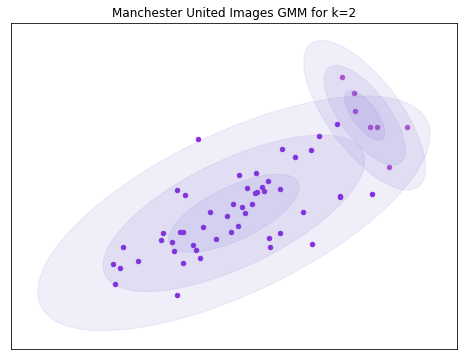

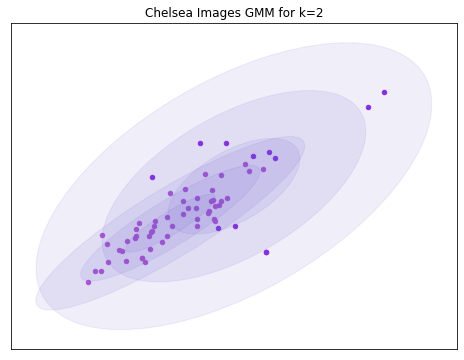

In [32]:
colorPalette = itertools.cycle(['blueviolet', 'mediumorchid'])
plotDataAndCont(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
                myModelManU.means_, myModelManU.covariances_, 2, colorPalette, 
                'Manchester United Images GMM for k=2')
plotDataAndCont(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
                myModelChelsea.means_, myModelChelsea.covariances_, 2, colorPalette, 
                'Chelsea Images GMM for k=2')

###  <font color=slateblue>Part B</font> ###

Plot BIC and AIC

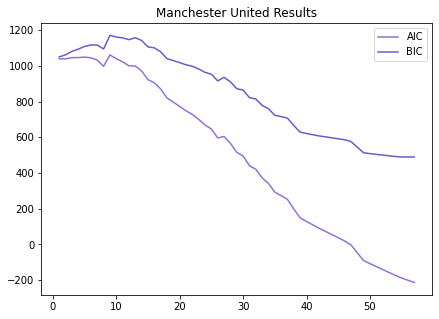

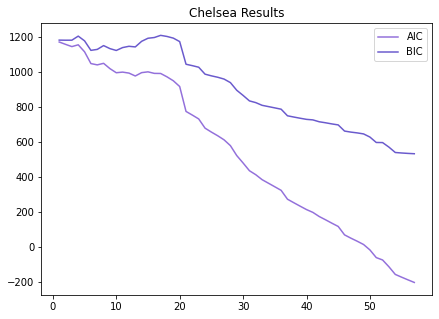

In [34]:
n_comp = np.arange(1,58)
modelsManU = [GaussianMixture(n, covariance_type='full',
                          random_state=0).fit(manUImgAvg) for n in n_comp]

fig = plt.figure(figsize=(7,5))
plt.plot(n_comp, [model.aic(np.array(manUImgAvg)) for model in modelsManU],
         label="AIC", color='mediumpurple')
plt.plot(n_comp, [model.bic(np.array(manUImgAvg)) for model in modelsManU], 
         label="BIC", color='slateblue')
plt.title("Manchester United Results")
plt.legend(loc='best')
plt.show()


modelsChelsea = [GaussianMixture(n, covariance_type='full',
                          random_state=0).fit(chelseaImgAvg) for n in n_comp]
fig = plt.figure(figsize=(7,5))
plt.plot(n_comp, [model.aic(np.array(chelseaImgAvg)) for model in modelsChelsea],
         label="AIC", color='mediumpurple')
plt.plot(n_comp, [model.bic(np.array(chelseaImgAvg)) for model in modelsChelsea], 
         label="BIC", color='slateblue')
plt.title("Chelsea Results")
plt.legend(loc='best')
plt.show()

Plot Ellipsoids and Contours for Various Values For Manchster United

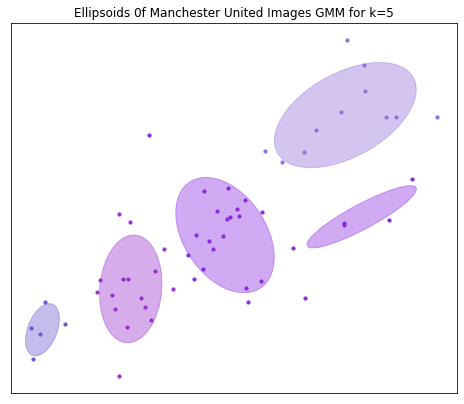

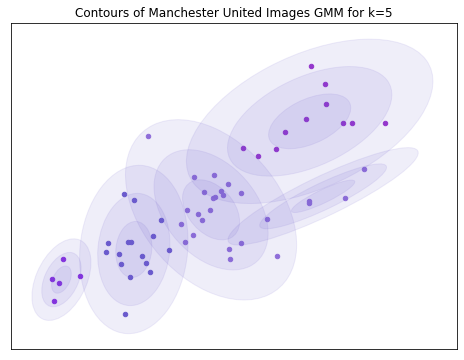

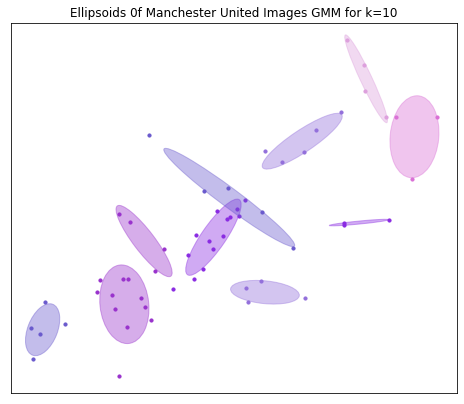

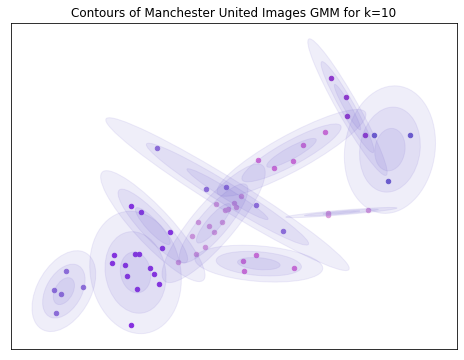

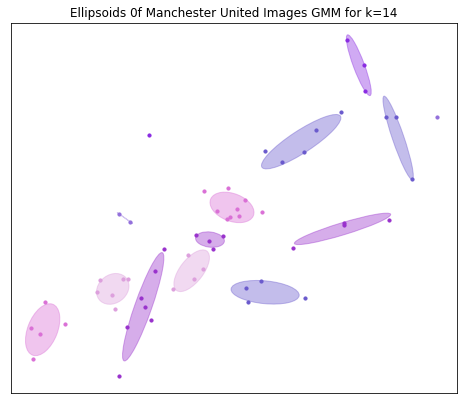

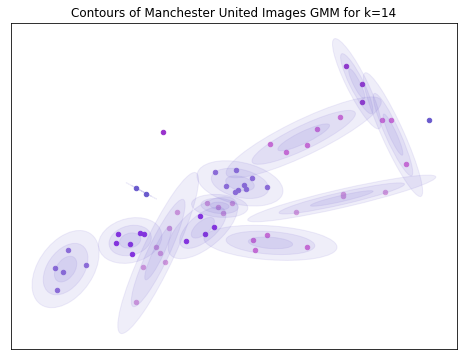

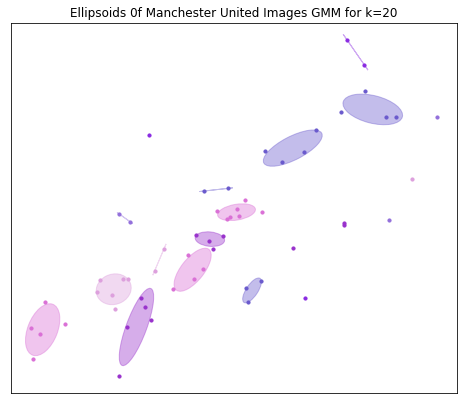

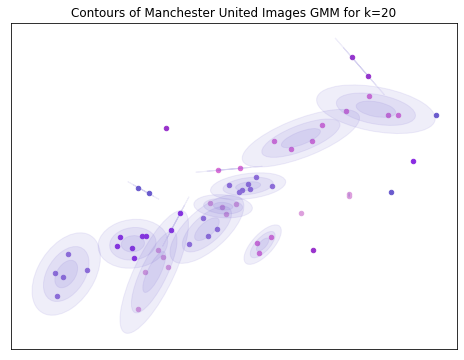

In [33]:
#k = 5
myModelManU = GaussianMixture(5, covariance_type='full', 
                              random_state=0).fit(manUImgAvg)

colorPalette = itertools.cycle(['blueviolet', 'mediumpurple', 'darkorchid', 
                                'slateblue'])
plotEllipsoids(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
               myModelManU.means_, myModelManU.covariances_, 0,
             'Ellipsoids 0f Manchester United Images GMM for k=5', colorPalette)
plotDataAndCont(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
                myModelManU.means_, myModelManU.covariances_, 5, colorPalette, 
                'Contours of Manchester United Images GMM for k=5')

#k = 10
myModelManU = GaussianMixture(10, covariance_type='full', 
                              random_state=0).fit(manUImgAvg)
colorPalette = itertools.cycle(['blueviolet', 'mediumpurple', 'darkorchid', 
                                'slateblue', 'plum', 'orchid'])
plotEllipsoids(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
               myModelManU.means_, myModelManU.covariances_, 0,
             'Ellipsoids 0f Manchester United Images GMM for k=10', colorPalette)
plotDataAndCont(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
                myModelManU.means_, myModelManU.covariances_, 10, colorPalette, 
                'Contours of Manchester United Images GMM for k=10')

#k = 14
myModelManU = GaussianMixture(14, covariance_type='full', 
                              random_state=0).fit(manUImgAvg)
plotEllipsoids(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
               myModelManU.means_, myModelManU.covariances_, 0,
             'Ellipsoids 0f Manchester United Images GMM for k=14', colorPalette)
plotDataAndCont(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
                myModelManU.means_, myModelManU.covariances_, 14, colorPalette, 
                'Contours of Manchester United Images GMM for k=14')

#k = 20
myModelManU = GaussianMixture(20, covariance_type='full', 
                              random_state=0).fit(manUImgAvg)
plotEllipsoids(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
               myModelManU.means_, myModelManU.covariances_, 0,
             'Ellipsoids 0f Manchester United Images GMM for k=20', colorPalette)
plotDataAndCont(np.array(manUImgAvg), myModelManU.predict(manUImgAvg), 
                myModelManU.means_, myModelManU.covariances_, 20, colorPalette, 
                'Contours of Manchester United Images GMM for k=20')

Plot Ellipsoids and Contours for Various Values For Chelsea

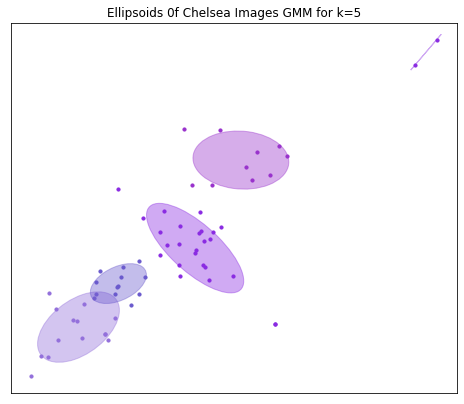

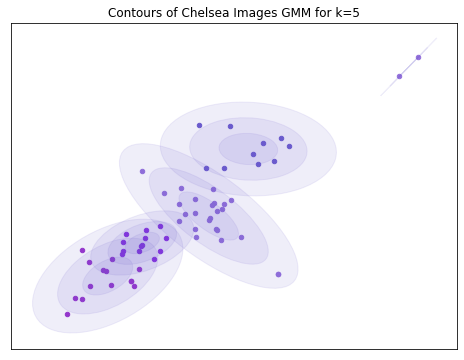

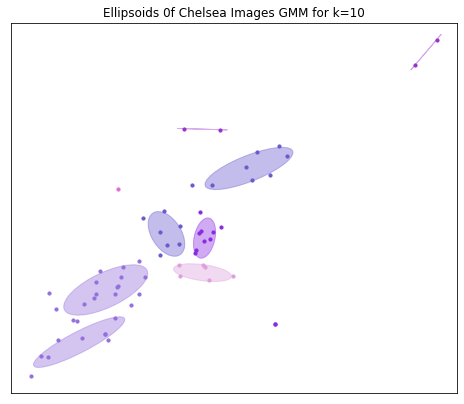

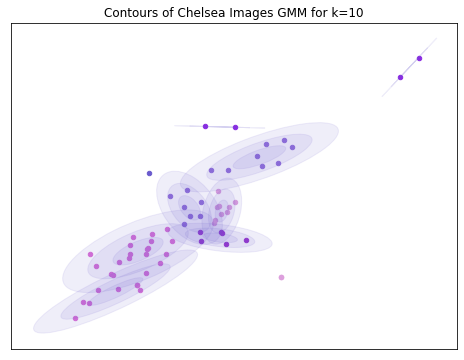

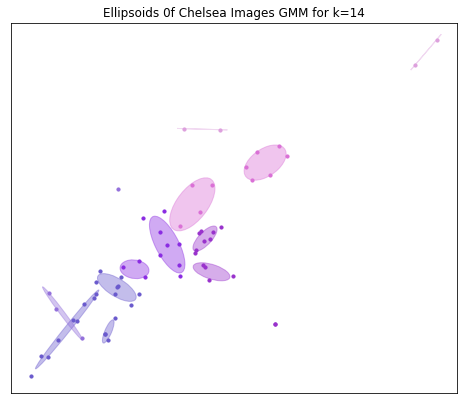

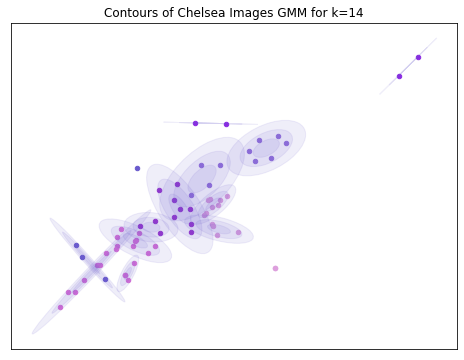

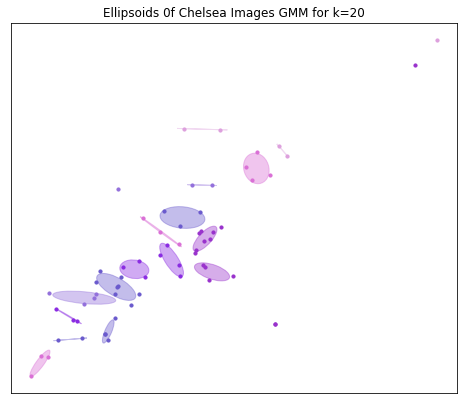

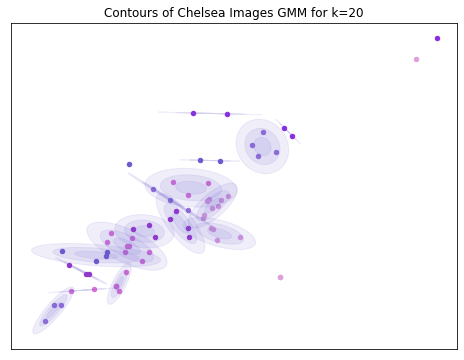

In [35]:
#k = 5
myModelChelsea = GaussianMixture(5, covariance_type='full', 
                              random_state=0).fit(chelseaImgAvg)

colorPalette = itertools.cycle(['blueviolet', 'mediumpurple', 'darkorchid', 
                                'slateblue'])
plotEllipsoids(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
               myModelChelsea.means_, myModelChelsea.covariances_, 0,
             'Ellipsoids 0f Chelsea Images GMM for k=5', colorPalette)
plotDataAndCont(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
                myModelChelsea.means_, myModelChelsea.covariances_, 5, colorPalette, 
                'Contours of Chelsea Images GMM for k=5')

#k = 10
myModelChelsea = GaussianMixture(10, covariance_type='full', 
                              random_state=0).fit(chelseaImgAvg)
colorPalette = itertools.cycle(['blueviolet', 'mediumpurple', 'darkorchid', 
                                'slateblue', 'plum', 'orchid'])
plotEllipsoids(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
               myModelChelsea.means_, myModelChelsea.covariances_, 0,
             'Ellipsoids 0f Chelsea Images GMM for k=10', colorPalette)
plotDataAndCont(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
                myModelChelsea.means_, myModelChelsea.covariances_, 10, colorPalette, 
                'Contours of Chelsea Images GMM for k=10')

#k = 14
myModelChelsea = GaussianMixture(14, covariance_type='full', 
                              random_state=0).fit(chelseaImgAvg)
plotEllipsoids(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
               myModelChelsea.means_, myModelChelsea.covariances_, 0,
             'Ellipsoids 0f Chelsea Images GMM for k=14', colorPalette)
plotDataAndCont(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
                myModelChelsea.means_, myModelChelsea.covariances_, 14, colorPalette, 
                'Contours of Chelsea Images GMM for k=14')

#k = 20
myModelChelsea = GaussianMixture(20, covariance_type='full', 
                              random_state=0).fit(chelseaImgAvg)
plotEllipsoids(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
               myModelChelsea.means_, myModelChelsea.covariances_, 0,
             'Ellipsoids 0f Chelsea Images GMM for k=20', colorPalette)
plotDataAndCont(np.array(chelseaImgAvg), myModelChelsea.predict(chelseaImgAvg), 
                myModelChelsea.means_, myModelChelsea.covariances_, 20, colorPalette, 
                'Contours of Chelsea Images GMM for k=20')

#  <font color=slateblue>Problem 8</font> #

Reading Dataset

In [3]:
ping = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/3/penguins.csv')
ping

species     island  ...  body_mass_g     sex
0    Adelie  Torgersen  ...       3750.0    MALE
1    Adelie  Torgersen  ...       3800.0  FEMALE
2    Adelie  Torgersen  ...       3250.0  FEMALE
3    Adelie  Torgersen  ...          NaN     NaN
4    Adelie  Torgersen  ...       3450.0  FEMALE
..      ...        ...  ...          ...     ...
339  Gentoo     Biscoe  ...          NaN     NaN
340  Gentoo     Biscoe  ...       4850.0  FEMALE
341  Gentoo     Biscoe  ...       5750.0    MALE
342  Gentoo     Biscoe  ...       5200.0  FEMALE
343  Gentoo     Biscoe  ...       5400.0    MALE

[344 rows x 7 columns]

Check for Missing Values

In [4]:
missingDataHeader = [name for name in ping.head() if (pd.isna(ping[name])).any()]
missingDataHeader

['culmen_length_mm',
 'culmen_depth_mm',
 'flipper_length_mm',
 'body_mass_g',
 'sex']

Remove the missing rows

In [5]:
print("Dataset's shape wihtout dropping the missing data is:", ping.shape, "\nAfter eliminating the missing data, dataset's shape is:", ping.dropna().shape)

Dataset's shape wihtout dropping the missing data is: (344, 7) 
After eliminating the missing data, dataset's shape is: (334, 7)


In [6]:
ping = ping.dropna()
missingDataHeader = [name for name in ping.head() if (pd.isna(ping[name])).any()]
missingDataHeader

[]

###  <font color=slateblue>Part A</font> ###

Plotting Scatterplot of Vairous Features

In [7]:
def plotClasses(dataset, feature1, feature2):

    plt.scatter(dataset[feature1][(dataset.species == "Gentoo")], dataset[feature2][(dataset.species == "Gentoo")],
                marker='*', color='mediumpurple', label="Gentoo")
    plt.scatter(dataset[feature1][(dataset.species == "Adelie")], dataset[feature2][(dataset.species == "Adelie")],
                marker='X', color='slateblue', label="Adelie")
    plt.scatter(dataset[feature1][(dataset.species == "Chinstrap")], dataset[feature2][(dataset.species == "Chinstrap")],
                marker = 'P', color = 'thistle', label = "Chinstrap")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(loc="lower right")
    plt.show()

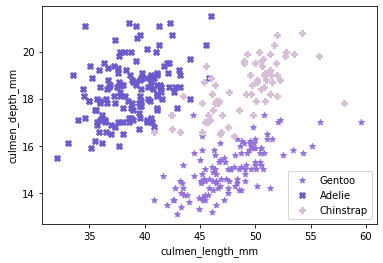

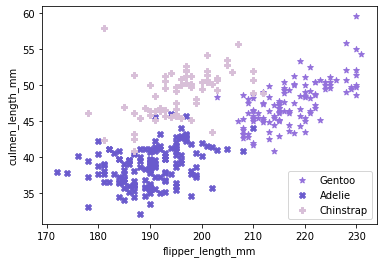

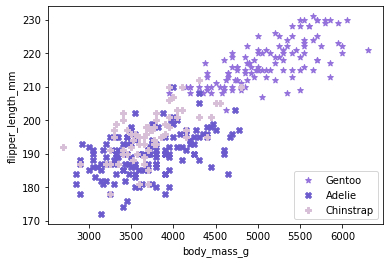

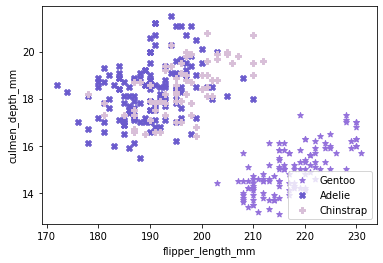

In [8]:
plotClasses(ping, "culmen_length_mm", "culmen_depth_mm")
plotClasses(ping, "flipper_length_mm", "culmen_length_mm")
plotClasses(ping, "body_mass_g", "flipper_length_mm")
plotClasses(ping, "flipper_length_mm", "culmen_depth_mm")

###  <font color=slateblue>Part B and C</font> ###

In [9]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))
  

In [10]:
def plotCont(mid, cov):
    ax = plt.gca()
    
    if cov.shape == (2, 2):
        U, S, Vt = LA.svd(cov)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(S)
    else:
        angle = 0
        width, height = 2 * np.sqrt(cov)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(mid, nsig * width, nsig * height, 
                             angle, alpha=0.1, color='slateblue'))

def plotDataAndCont(data, predLabels, mu, sigma, order, colorPalette, title):
  fig = plt.figure(figsize=(8,6))

  for i in range(order):
    plotCont(mu[i], sigma[i])

  for i, (_, color) in enumerate(zip(data, colorPalette)):
    plt.scatter(data[predLabels == i, 0], data[predLabels == i, 1], 20, 
                color=color)

  plt.xticks(())
  plt.yticks(())
  plt.title(title)
  plt.show()

In [11]:
def fitGMMandPlot(dataset, numComp, featureName1, featureName2, species):
  myModel = GaussianMixture(numComp, covariance_type='full', 
                            random_state=0).fit(dataset)
  colorPalette = itertools.cycle(['blueviolet', 'mediumpurple', 'darkorchid', 
                                'slateblue', 'plum', 'orchid'])
  plotDataAndCont(dataset.to_numpy(), myModel.predict(dataset.to_numpy()), 
                  myModel.means_, myModel.covariances_, numComp, colorPalette,
                  'Contours of ' + species + ' for ' + featureName1 + ' and ' + featureName2 +  ' for k=' + str(numComp))
  
  dictTable = {1:["Mean", "Covariance"]}
  for i in range(0,numComp):
    dictTable[i+2] = [(myModel.means_[i]), (myModel.covariances_[i])]

  nameTable = ['Component ' + str(i) for i in range(1,numComp+1)]
  
  plotTable(dictTable, nameTable, numComp)

  return (myModel.score(dataset))


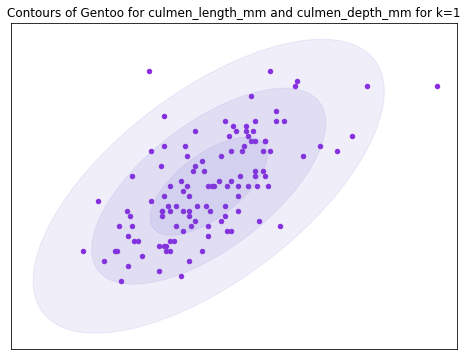

╒════════════╤═══════════════════════════╕
│            │ Component 1               │
╞════════════╪═══════════════════════════╡
│    Mean    │ [47.5425 15.0025]         │
├────────────┼───────────────────────────┤
│ Covariance │ [[9.56494475 1.95181042]  │
│            │  [1.95181042 0.96007808]] │
╘════════════╧═══════════════════════════╛


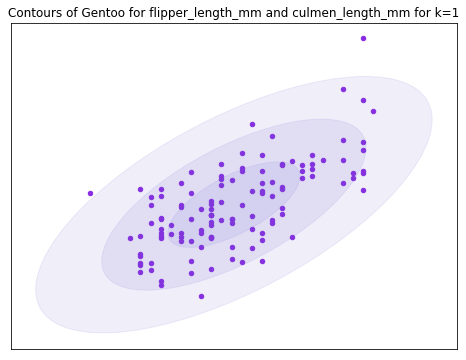

╒════════════╤═════════════════════════════╕
│            │ Component 1                 │
╞════════════╪═════════════════════════════╡
│    Mean    │ [217.23333333  47.5425    ] │
├────────────┼─────────────────────────────┤
│ Covariance │ [[42.64555656 13.36591667]  │
│            │  [13.36591667  9.56494475]] │
╘════════════╧═════════════════════════════╛


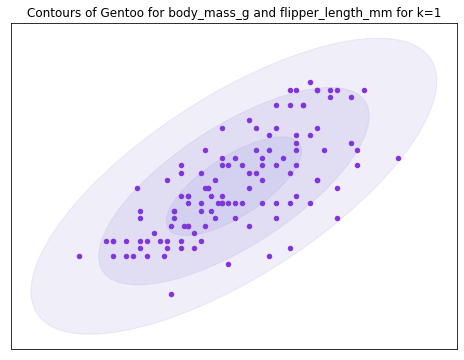

╒════════════╤═══════════════════════════════════╕
│            │ Component 1                       │
╞════════════╪═══════════════════════════════════╡
│    Mean    │ [5090.625       217.23333333]     │
├────────────┼───────────────────────────────────┤
│ Covariance │ [[2.47677734e+05 2.31031250e+03]  │
│            │  [2.31031250e+03 4.26455566e+01]] │
╘════════════╧═══════════════════════════════════╛


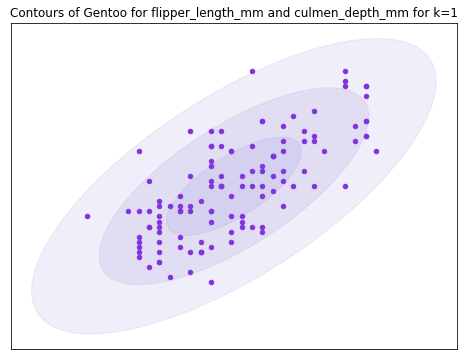

╒════════════╤═════════════════════════════╕
│            │ Component 1                 │
╞════════════╪═════════════════════════════╡
│    Mean    │ [217.23333333  15.0025    ] │
├────────────┼─────────────────────────────┤
│ Covariance │ [[42.64555656  4.53608333]  │
│            │  [ 4.53608333  0.96007808]] │
╘════════════╧═════════════════════════════╛


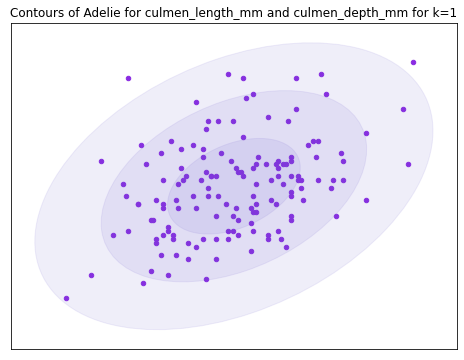

╒════════════╤═══════════════════════════╕
│            │ Component 1               │
╞════════════╪═══════════════════════════╡
│    Mean    │ [38.8239726  18.34726027] │
├────────────┼───────────────────────────┤
│ Covariance │ [[7.04086467 1.24400403]  │
│            │  [1.24400403 1.47660308]] │
╘════════════╧═══════════════════════════╛


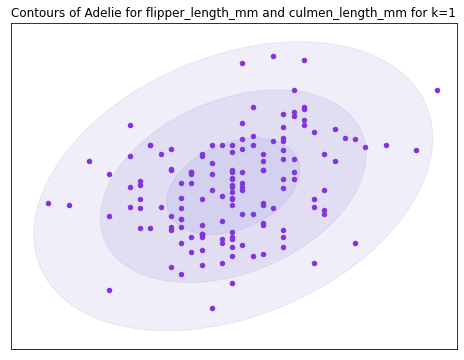

╒════════════╤═════════════════════════════╕
│            │ Component 1                 │
╞════════════╪═════════════════════════════╡
│    Mean    │ [190.10273973  38.8239726 ] │
├────────────┼─────────────────────────────┤
│ Covariance │ [[42.24287021  5.73041377]  │
│            │  [ 5.73041377  7.04086467]] │
╘════════════╧═════════════════════════════╛


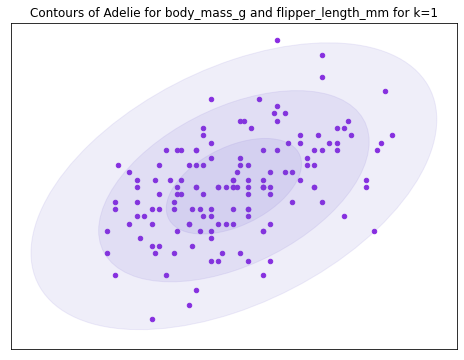

╒════════════╤═══════════════════════════════════╕
│            │ Component 1                       │
╞════════════╪═══════════════════════════════════╡
│    Mean    │ [3706.16438356  190.10273973]     │
├────────────┼───────────────────────────────────┤
│ Covariance │ [[2.08891795e+05 1.38087352e+03]  │
│            │  [1.38087352e+03 4.22428702e+01]] │
╘════════════╧═══════════════════════════════════╛


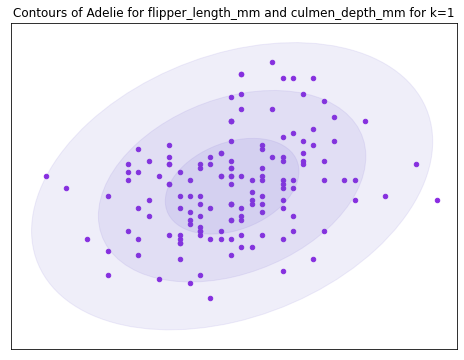

╒════════════╤═════════════════════════════╕
│            │ Component 1                 │
╞════════════╪═════════════════════════════╡
│    Mean    │ [190.10273973  18.34726027] │
├────────────┼─────────────────────────────┤
│ Covariance │ [[42.24287021  2.45541847]  │
│            │  [ 2.45541847  1.47660308]] │
╘════════════╧═════════════════════════════╛


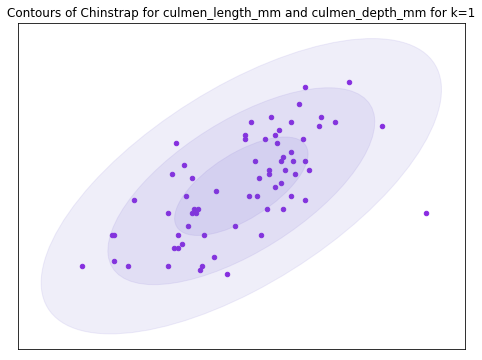

╒════════════╤═════════════════════════════╕
│            │ Component 1                 │
╞════════════╪═════════════════════════════╡
│    Mean    │ [48.83382353 18.42058824]   │
├────────────┼─────────────────────────────┤
│ Covariance │ [[10.98665109  2.44136246]  │
│            │  [ 2.44136246  1.27016536]] │
╘════════════╧═════════════════════════════╛


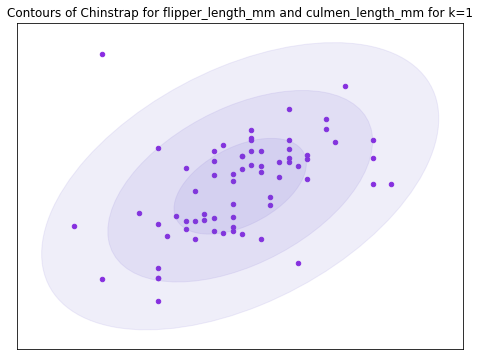

╒════════════╤═════════════════════════════╕
│            │ Component 1                 │
╞════════════╪═════════════════════════════╡
│    Mean    │ [195.82352941  48.83382353] │
├────────────┼─────────────────────────────┤
│ Covariance │ [[50.11591796 11.06626298]  │
│            │  [11.06626298 10.98665109]] │
╘════════════╧═════════════════════════════╛


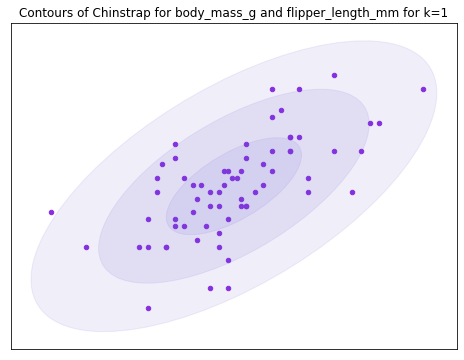

╒════════════╤═══════════════════════════════════╕
│            │ Component 1                       │
╞════════════╪═══════════════════════════════════╡
│    Mean    │ [3733.08823529  195.82352941]     │
├────────────┼───────────────────────────────────┤
│ Covariance │ [[1.45541198e+05 1.73267734e+03]  │
│            │  [1.73267734e+03 5.01159180e+01]] │
╘════════════╧═══════════════════════════════════╛


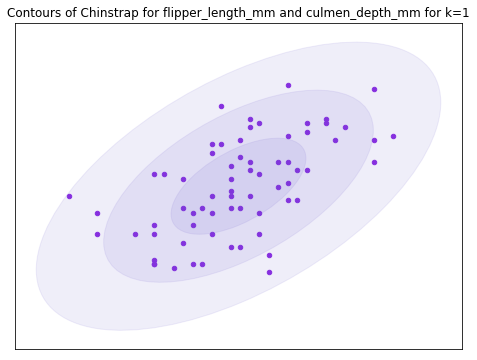

╒════════════╤═════════════════════════════╕
│            │ Component 1                 │
╞════════════╪═════════════════════════════╡
│    Mean    │ [195.82352941  18.42058824] │
├────────────┼─────────────────────────────┤
│ Covariance │ [[50.11591796  4.62863322]  │
│            │  [ 4.62863322  1.27016536]] │
╘════════════╧═════════════════════════════╛
The maximum value of likelihood is: -3.6786 which is for Gentoo pinguin with culmen_length_mm culmen_depth_mm and  as its selected features
The maximum value of likelihood is: -3.9280 which is for Adelie pinguin with culmen_length_mm culmen_depth_mm and  as its selected features
The maximum value of likelihood is: -3.8773 which is for Chinstrap pinguin with culmen_length_mm culmen_depth_mm and  as its selected features



In [12]:
features = [["culmen_length_mm", "culmen_depth_mm"], 
            ["flipper_length_mm", "culmen_length_mm"], 
            ["body_mass_g", "flipper_length_mm"], 
            ["flipper_length_mm", "culmen_depth_mm"]]
species = ["Gentoo", "Adelie", "Chinstrap"]
plots = [fitGMMandPlot(pd.concat([ping[feature1][ping.species == spc],
                          ping[feature2][ping.species == spc]], 
                         axis=1, sort=False), 1, feature1, feature2, 
               spc) for spc in species for feature1,feature2 in features]

[print('The maximum value of likelihood is: %1.4f which is for ' %(max(plots[i:i+4])) + 
      species[divmod(plots.index(max(plots[i:i+4])),4)[0]] + ' pinguin with ' +
      features[divmod(plots.index(max(plots[i:i+4])),4)[1]][0] + ' ' +
      features[divmod(plots.index(max(plots[i:i+4])),4)[1]][1] + ' and ' + 
      ' as its selected features') for i in [0,4,8]]
print('')

###  <font color=slateblue>Part D</font> ###

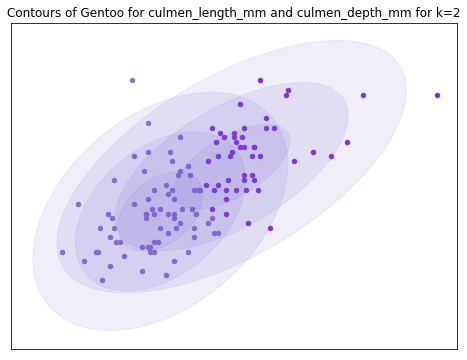

╒════════════╤═══════════════════════════╤═══════════════════════════╕
│            │        Component 1        │ Component 2               │
╞════════════╪═══════════════════════════╪═══════════════════════════╡
│    Mean    │ [49.37091382 15.48639434] │ [45.81421204 14.54510423] │
├────────────┼───────────────────────────┼───────────────────────────┤
│ Covariance │ [[8.43314366 1.55537269]  │ [[4.48776234 0.69971843]  │
│            │  [1.55537269 0.78205371]] │  [0.69971843 0.69781154]] │
╘════════════╧═══════════════════════════╧═══════════════════════════╛


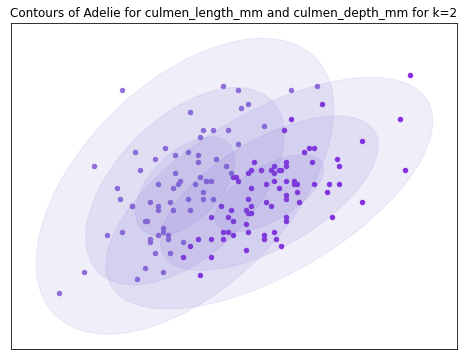

╒════════════╤═══════════════════════════╤═══════════════════════════╕
│            │        Component 1        │ Component 2               │
╞════════════╪═══════════════════════════╪═══════════════════════════╡
│    Mean    │ [40.42092904 18.25559919] │ [37.08920237 18.44683151] │
├────────────┼───────────────────────────┼───────────────────────────┤
│ Covariance │ [[4.65078999 1.42224089]  │ [[3.85741723 1.38212986]  │
│            │  [1.42224089 1.12696823]] │  [1.38212986 1.83736941]] │
╘════════════╧═══════════════════════════╧═══════════════════════════╛


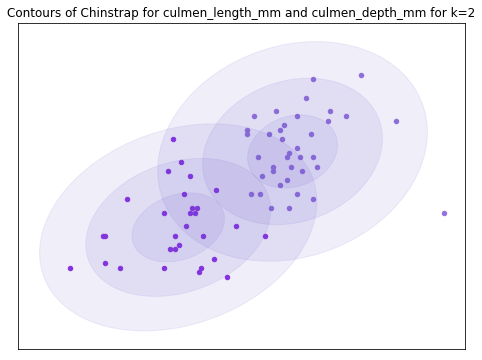

╒════════════╤═══════════════════════════╤═══════════════════════════╕
│            │        Component 1        │ Component 2               │
╞════════════╪═══════════════════════════╪═══════════════════════════╡
│    Mean    │ [45.85601008 17.47873238] │ [51.07447557 19.1292865 ] │
├────────────┼───────────────────────────┼───────────────────────────┤
│ Covariance │ [[4.45222351 0.39132921]  │ [[4.21070768 0.28558998]  │
│            │  [0.39132921 0.56251373]] │  [0.28558998 0.6328921 ]] │
╘════════════╧═══════════════════════════╧═══════════════════════════╛


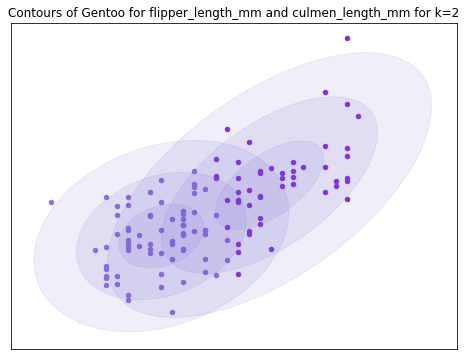

╒════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │ Component 2                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [222.90080504  49.54644247] │ [213.04757149  46.06247039] │
├────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[24.24575139  8.82615834]  │ [[14.99160795  2.13571834]  │
│            │  [ 8.82615834  9.10538342]] │  [ 2.13571834  4.74797605]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╛


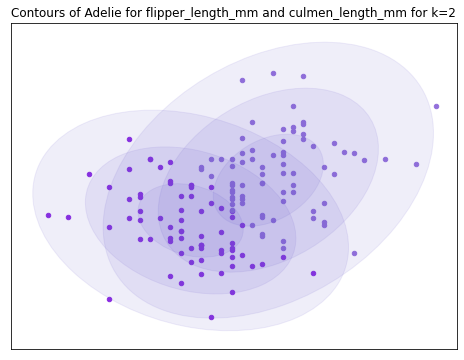

╒════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │ Component 2                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [185.98409961  37.58102433] │ [193.58769517  39.87568366] │
├────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[26.53494043 -2.62545812]  │ [[29.03582168  4.80388455]  │
│            │  [-2.62545812  4.38980727]] │  [ 4.80388455  6.87071777]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╛


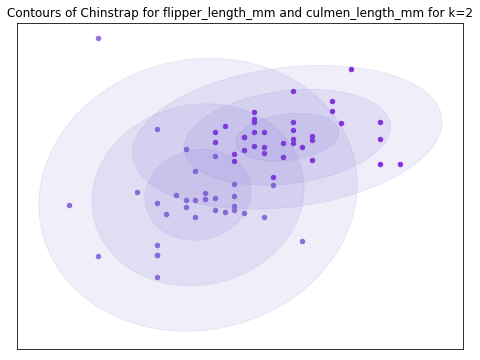

╒════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │ Component 2                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [200.4547949   50.90176207] │ [191.26166239  46.79687258] │
├────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[28.17214632  1.96236109]  │ [[29.79301912  1.30778498]  │
│            │  [ 1.96236109  2.92908225]] │  [ 1.30778498 10.56202056]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╛


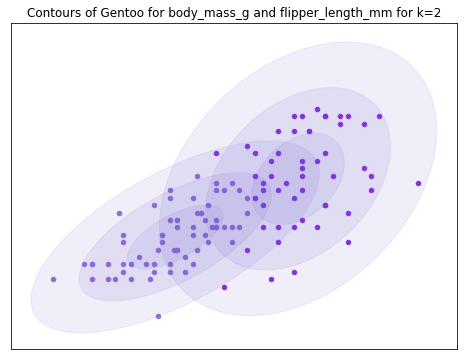

╒════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │            Component 1            │ Component 2                       │
╞════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │   [5527.40813162  221.56633796]   │ [4735.5943558   213.71133509]     │
├────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[8.86834888e+04 6.46528343e+02]  │ [[9.57949490e+04 8.73920254e+02]  │
│            │  [6.46528343e+02 3.80582931e+01]] │  [8.73920254e+02 1.87089178e+01]] │
╘════════════╧═══════════════════════════════════╧═══════════════════════════════════╛


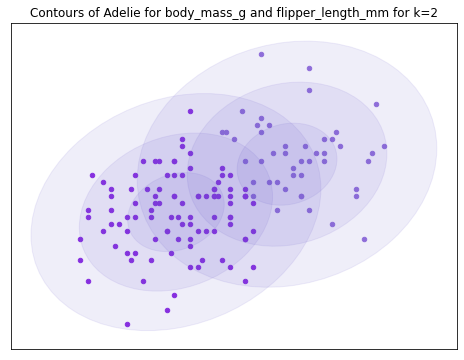

╒════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │            Component 1            │ Component 2                       │
╞════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │   [3459.25446718  187.73528994]   │ [4163.34406621  194.48632204]     │
├────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[9.37799272e+04 3.33485493e+02]  │ [[1.00138067e+05 2.33787921e+02]  │
│            │  [3.33485493e+02 3.10205711e+01]] │  [2.33787921e+02 3.34284325e+01]] │
╘════════════╧═══════════════════════════════════╧═══════════════════════════════════╛


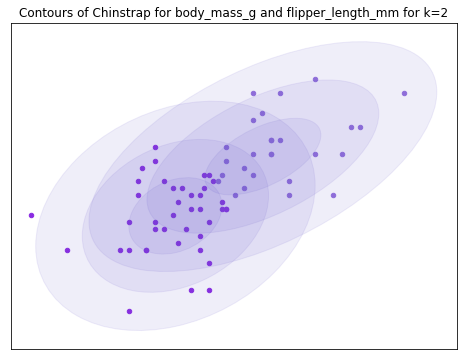

╒════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │            Component 1            │ Component 2                       │
╞════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │   [3512.98551351  191.93907311]   │ [4005.37171271  200.62889147]     │
├────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[6.87401199e+04 3.88782521e+02]  │ [[1.06481231e+05 1.02908146e+03]  │
│            │  [3.88782521e+02 3.13802398e+01]] │  [1.02908146e+03 3.15356253e+01]] │
╘════════════╧═══════════════════════════════════╧═══════════════════════════════════╛


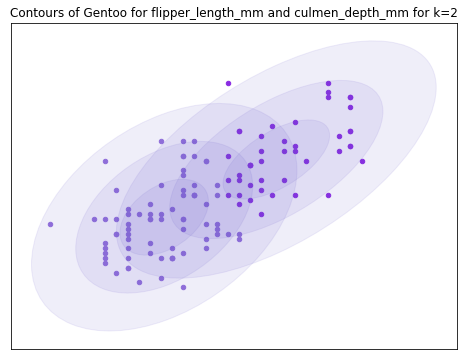

╒════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │ Component 2                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [223.34638563  15.72216488] │ [213.29018211  14.53828878] │
├────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[22.86683546  2.35498787]  │ [[15.7504527   1.27477038]  │
│            │  [ 2.35498787  0.65826587]] │  [ 1.27477038  0.60518988]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╛


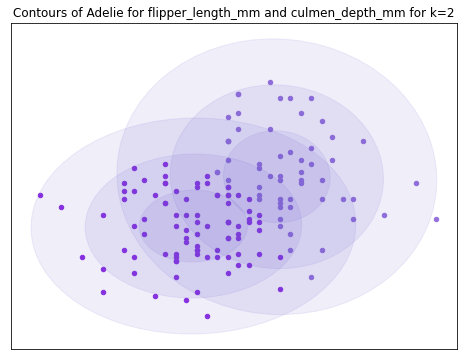

╒════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │ Component 2                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [186.69661465  17.80802297] │ [194.69376471  19.07408382] │
├────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[26.95316238  0.07522338]  │ [[26.13634318 -0.14889716]  │
│            │  [ 0.07522338  0.85559077]] │  [-0.14889716  1.39344615]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╛


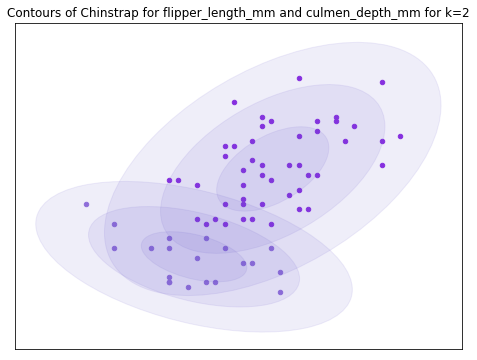

╒════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │ Component 2                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [198.20131992  18.9247809 ] │ [189.69858081  17.12183878] │
├────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[36.734553    2.63623266]  │ [[32.50612479 -1.28207166]  │
│            │  [ 2.63623266  0.75104944]] │  [-1.28207166  0.26578553]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╛


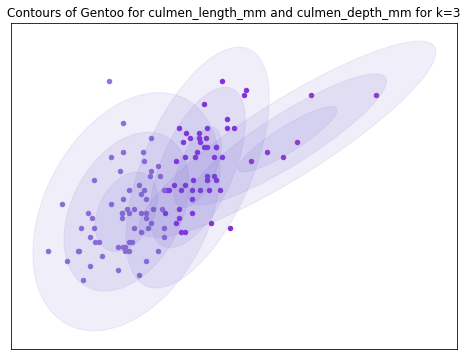

╒════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│            │        Component 1        │        Component 2        │ Component 3               │
╞════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│    Mean    │ [49.43625414 15.46812922] │ [45.37634212 14.53769284] │ [54.56242258 16.06372405] │
├────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│ Covariance │ [[1.85591667 0.66512125]  │ [[3.16669726 0.51801761]  │ [[7.97158694 1.72894929]  │
│            │  [0.66512125 0.71547589]] │  [0.51801761 0.69989868]] │  [1.72894929 0.47532248]] │
╘════════════╧═══════════════════════════╧═══════════════════════════╧═══════════════════════════╛


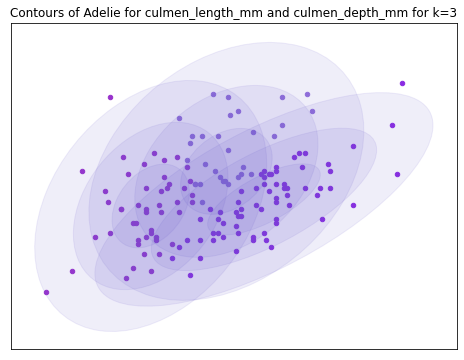

╒════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│            │        Component 1        │        Component 2        │ Component 3               │
╞════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│    Mean    │ [40.60964494 18.17020739] │ [39.13998918 18.97502415] │ [36.18026366 17.98097332] │
├────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│ Covariance │ [[4.8577647  1.56208766]  │ [[3.21250234 0.69675176]  │ [[2.28757291 0.60575081]  │
│            │  [1.56208766 1.04560079]] │  [0.69675176 1.52504758]] │  [0.60575081 1.44476285]] │
╘════════════╧═══════════════════════════╧═══════════════════════════╧═══════════════════════════╛


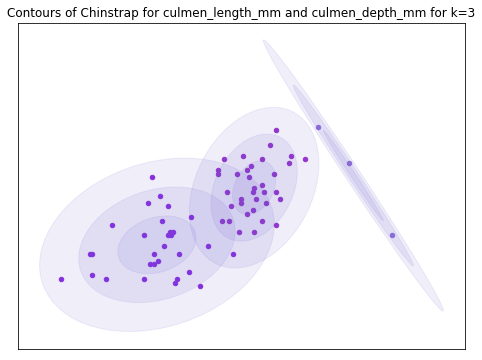

╒════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════════════╕
│            │        Component 1        │         Component 2         │ Component 3               │
╞════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════════════╡
│    Mean    │ [45.84545809 17.54056383] │  [56.01970001 19.4520465 ]  │ [50.88057117 19.11697951] │
├────────────┼───────────────────────────┼─────────────────────────────┼───────────────────────────┤
│ Covariance │ [[4.10497871 0.37958597]  │ [[ 2.41774687 -1.92822353]  │ [[1.25017491 0.2463138 ]  │
│            │  [0.37958597 0.63481233]] │  [-1.92822353  1.55312943]] │  [0.2463138  0.54476297]] │
╘════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════════════╛


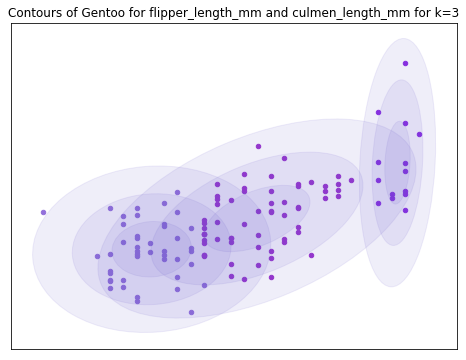

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │ Component 3                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [229.43125615  52.1239746 ] │ [211.10411559  45.62155971] │ [218.95444275  47.9292036 ] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │  [[0.89870473 0.46476248]   │  [[8.76044361 0.35930389]   │ [[15.62562278  4.88749376]  │
│            │   [0.46476248 9.66752243]]  │   [0.35930389 4.34526117]]  │  [ 4.88749376  6.2116805 ]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╧═════════════════════════════╛


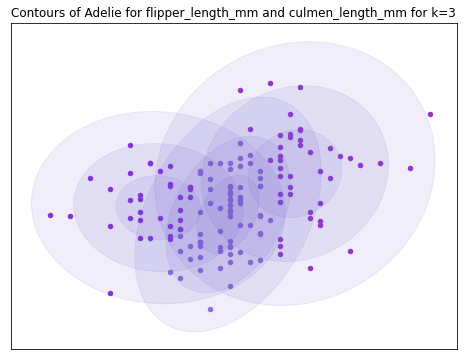

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │ Component 3                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [182.8090483   38.34196619] │ [189.78480697  37.92091645] │ [196.4906776   40.44072286] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[17.90719542 -0.38317942]  │  [[9.66301446 2.6905248 ]   │ [[21.85071683  1.25293175]  │
│            │  [-0.38317942  3.90311749]] │   [2.6905248  5.82078443]]  │  [ 1.25293175  7.34800149]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╧═════════════════════════════╛


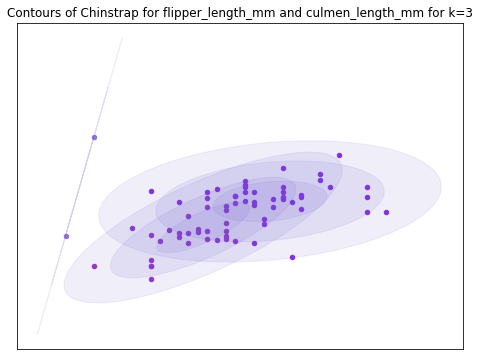

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │ Component 3                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [199.66703373  50.22595562] │ [179.50001103  52.05004376] │ [192.58147147  47.07425221] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[36.63353549  3.51158984]  │   [[ 2.250001  8.925   ]    │ [[24.1504021  11.32423116]  │
│            │  [ 3.51158984  5.92209249]] │    [ 8.925    35.402501]]   │  [11.32423116  9.15055038]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╧═════════════════════════════╛


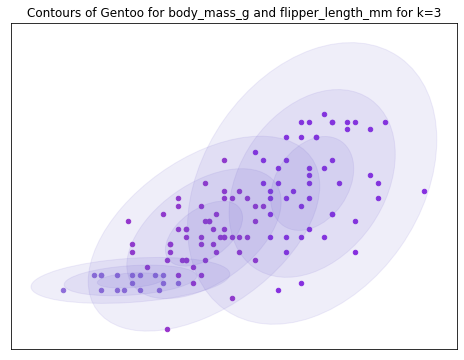

╒════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │            Component 1            │            Component 2            │ Component 3                       │
╞════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │    [5573.1375954  221.9419722]    │   [4389.84741334  209.28724854]   │ [4868.73748885  215.38885898]     │
├────────────┼───────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[7.31567770e+04 5.13903959e+02]  │ [[4.65589274e+04 6.02673771e+01]  │ [[6.31044055e+04 5.20943162e+02]  │
│            │  [5.13903959e+02 3.75491482e+01]] │  [6.02673771e+01 9.98728742e-01]] │  [5.20943162e+02 1.79808808e+01]] │
╘════════════╧═══════════════════════════════════╧═══════════════════════════════════╧═══════════════════════════════════╛


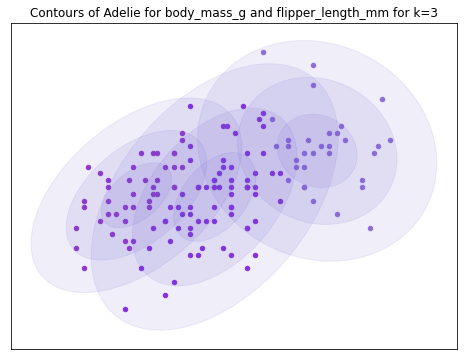

╒════════════╤═══════════════════════════════════╤═════════════════════════════════════╤═══════════════════════════════════╕
│            │            Component 1            │             Component 2             │ Component 3                       │
╞════════════╪═══════════════════════════════════╪═════════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │   [3701.06786554  188.5293012 ]   │    [4328.72827383  195.33257565]    │ [3222.41334717  188.7747543 ]     │
├────────────┼───────────────────────────────────┼─────────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[6.34355030e+04 7.35163540e+02]  │ [[ 5.95048806e+04 -1.48507765e+02]  │ [[4.62378640e+04 5.11407924e+02]  │
│            │  [7.35163540e+02 4.30739531e+01]] │  [-1.48507765e+02  2.95400877e+01]] │  [5.11407924e+02 2.29723618e+01]] │
╘════════════╧═══════════════════════════════════╧═════════════════════════════════════╧═══════════════════════════════════╛


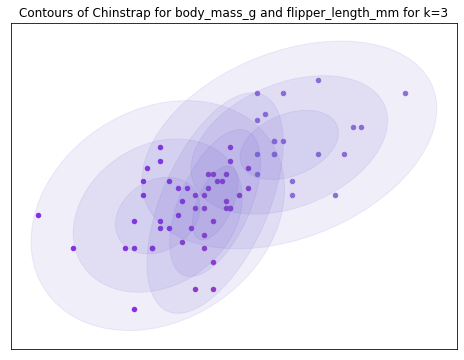

╒════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │            Component 1            │            Component 2            │ Component 3                       │
╞════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │   [3384.7819855   191.87380115]   │   [4137.44035521  202.36422556]   │ [3713.04605068  193.73478022]     │
├────────────┼───────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[5.84475028e+04 3.12525599e+02]  │ [[7.91182304e+04 5.05351182e+02]  │ [[16873.30716744   388.04428802]  │
│            │  [3.12525599e+02 3.23777178e+01]] │  [5.05351182e+02 2.64306375e+01]] │  [  388.04428802    29.81461185]] │
╘════════════╧═══════════════════════════════════╧═══════════════════════════════════╧═══════════════════════════════════╛


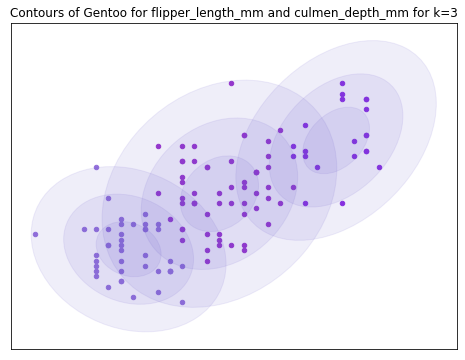

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │ Component 3                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [227.53666015  16.20117228] │ [210.64080791  14.11638057] │ [218.03745381  15.1797927 ] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │  [[7.40495575 0.6395283 ]   │ [[ 6.99747439 -0.25038267]  │ [[10.15197113  0.51011965]  │
│            │   [0.6395283  0.40749721]]  │  [-0.25038267  0.27869523]] │  [ 0.51011965  0.52706249]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╧═════════════════════════════╛


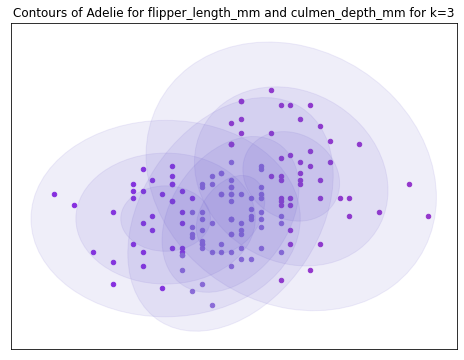

╒════════════╤═══════════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │            Component 1            │         Component 2         │ Component 3                 │
╞════════════╪═══════════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │    [183.3410946   17.92304575]    │ [189.92604831  18.03955874] │ [196.08824811  19.10003448] │
├────────────┼───────────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[2.07448119e+01 9.27769568e-03]  │ [[12.06762791  1.26157032]  │ [[24.11896551 -0.96080899]  │
│            │  [9.27769568e-03 8.34185921e-01]] │  [ 1.26157032  1.18023764]] │  [-0.96080899  1.56045441]] │
╘════════════╧═══════════════════════════════════╧═════════════════════════════╧═════════════════════════════╛


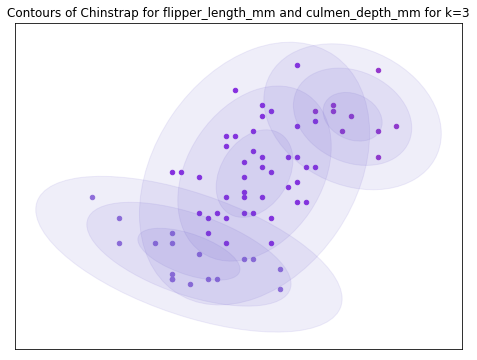

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │ Component 3                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [196.20256725  18.66584528] │ [188.85410861  17.08741933] │ [207.18566835  19.77818834] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[18.46606245  1.12841601]  │ [[32.71882856 -1.66303319]  │ [[10.97765962 -0.36625675]  │
│            │  [ 1.12841601  0.73479726]] │  [-1.66303319  0.25828351]] │  [-0.36625675  0.22685241]] │
╘════════════╧═════════════════════════════╧═════════════════════════════╧═════════════════════════════╛


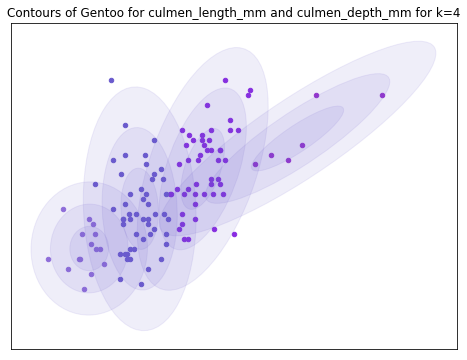

╒════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═════════════════════════════╕
│            │        Component 1        │        Component 2        │        Component 3        │ Component 4                 │
╞════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═════════════════════════════╡
│    Mean    │ [49.54951099 15.51131912] │ [43.19518221 13.91061846] │ [54.86208064 16.1229649 ] │ [46.01969707 14.70921599]   │
├────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┼─────────────────────────────┤
│ Covariance │ [[1.49497794 0.51227675]  │ [[1.18153615 0.00554313]  │ [[6.6694876  1.47497405]  │ [[ 1.10818294 -0.06281408]  │
│            │  [0.51227675 0.66205857]] │  [0.00554313 0.19927236]] │  [1.47497405 0.42537496]] │  [-0.06281408  0.66748516]] │
╘════════════╧═══════════════════════════╧═══════════════════════════╧═══════════════════════════

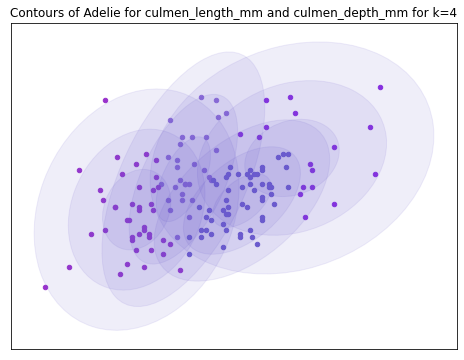

╒════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│            │        Component 1        │        Component 2        │        Component 3        │ Component 4               │
╞════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│    Mean    │ [42.3629443  19.36725343] │ [37.84843752 18.72957989] │ [35.90673942 17.81793962] │ [40.28258904 18.09194865] │
├────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│ Covariance │ [[3.86299805 0.43471095]  │ [[1.27185911 0.80288122]  │ [[2.016164   0.33477463]  │ [[1.47792676 0.4971877 ]  │
│            │  [0.43471095 1.34400679]] │  [0.80288122 1.61811576]] │  [0.33477463 1.45416567]] │  [0.4971877  0.64870093]] │
╘════════════╧═══════════════════════════╧═══════════════════════════╧═══════════════════════════╧═════════════

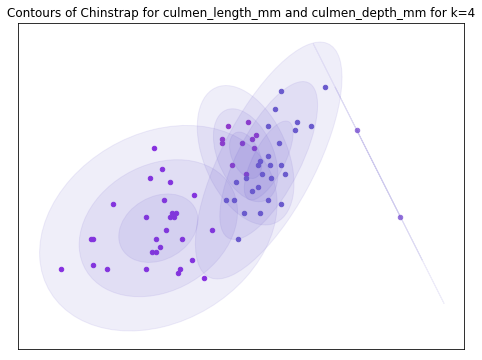

╒════════════╤═══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════════════╕
│            │        Component 1        │        Component 2        │         Component 3         │ Component 4               │
╞════════════╪═══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════════════╡
│    Mean    │ [45.79945743 17.54127897] │ [56.9000014  18.79999873] │  [50.19730568 19.22413549]  │ [51.35969611 19.10275242] │
├────────────┼───────────────────────────┼───────────────────────────┼─────────────────────────────┼───────────────────────────┤
│ Covariance │ [[3.97915434 0.37819609]  │  [[ 1.210001 -1.1     ]   │ [[ 0.66003882 -0.17699213]  │ [[1.51604388 0.7854114 ]  │
│            │  [0.37819609 0.62436592]] │   [-1.1       1.000001]]  │  [-0.17699213  0.28749419]] │  [0.7854114  0.82981702]] │
╘════════════╧═══════════════════════════╧═══════════════════════════╧═══════════════════════════

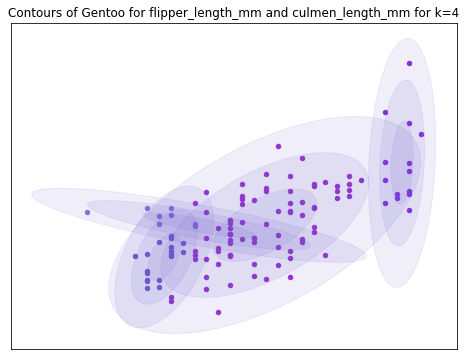

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │ Component 4                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [229.43924913  52.10720084] │ [212.38217281  47.42468594] │ [217.89477184  47.43928407] │ [209.45412616  45.04392372] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │  [[0.88722741 0.47963801]   │ [[21.94489901 -3.61377794]  │ [[19.06369365  6.89027448]  │ [[1.92034257 1.23116545]    │
│            │   [0.47963801 9.71548153]]  │  [-3.61377794  0.86156187]] │  [ 6.89027448  7.39393331]] │  [1.23116545 3.14729704]]   │
╘════════════╧═════════════════════════════╧═══════════

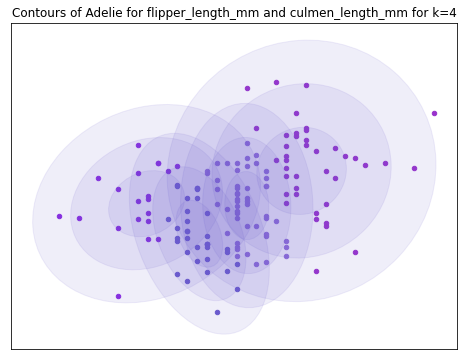

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │ Component 4                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [180.87060034  38.64474221] │ [191.01633068  38.5319078 ] │ [196.56683882  40.62423002] │ [186.21375481  36.83047683] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[14.79195096  1.35475111]  │ [[ 5.00100842 -0.13934468]  │ [[20.589173    0.56986745]  │ [[ 5.58291912 -1.69332399]  │
│            │  [ 1.35475111  3.98141128]] │  [-0.13934468  4.22335141]] │  [ 0.56986745  6.92049855]] │  [-1.69332399  4.08079815]] │
╘════════════╧═════════════════════════════╧═══════════

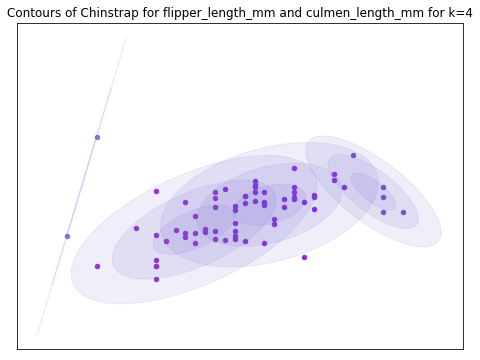

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │ Component 4                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [198.49765404  49.82055998] │ [179.50001146  52.05004544] │ [190.87501542  46.82492269] │ [209.01573072  51.41526578] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[13.4994811   3.19879177]  │   [[ 2.250001  8.925   ]    │ [[17.19895007  7.34436877]  │ [[ 5.22229845 -3.74419139]  │
│            │  [ 3.19879177  6.22778784]] │    [ 8.925    35.402501]]   │  [ 7.34436877  8.86625344]] │  [-3.74419139  4.95993194]] │
╘════════════╧═════════════════════════════╧═══════════

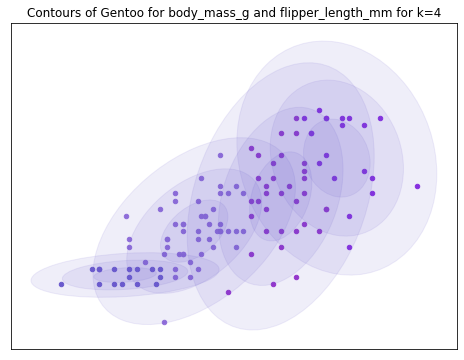

╒════════════╤═════════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │             Component 1             │            Component 2            │            Component 3            │ Component 4                       │
╞════════════╪═════════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │    [5768.46313534  224.65237327]    │   [4827.21934657  215.03056818]   │   [5398.1473333   219.60891983]   │ [4371.00508969  209.24748384]     │
├────────────┼─────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[ 4.83510536e+04 -1.52939569e+02]  │ [[4.95820429e+04 4.21962695e+02]  │ [[4.22842506e+04 3.62050118e+02]  │ [[4.28200880e+04 5.00808106e+01]  │
│            │  [-1.52939569e+02  

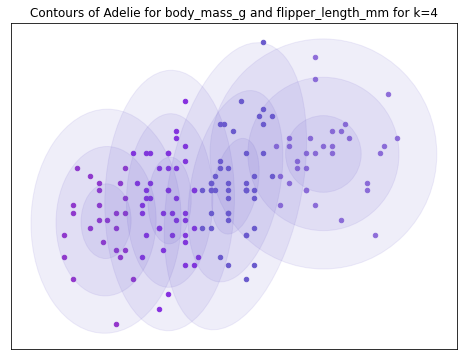

╒════════════╤═══════════════════════════════════╤═════════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │            Component 1            │             Component 2             │            Component 3            │ Component 4                       │
╞════════════╪═══════════════════════════════════╪═════════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │   [3460.89037447  188.63772055]   │    [4350.11743507  194.90645147]    │   [3093.3113402   185.85029093]   │ [3841.20697164  190.56206399]     │
├────────────┼───────────────────────────────────┼─────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[15619.57031884    18.12570994]  │ [[ 4.77921118e+04 -1.54749987e+00]  │ [[2.09498404e+04 1.44688539e+01]  │ [[18836.07675771   277.80320775]  │
│            │  [   18.12570994   

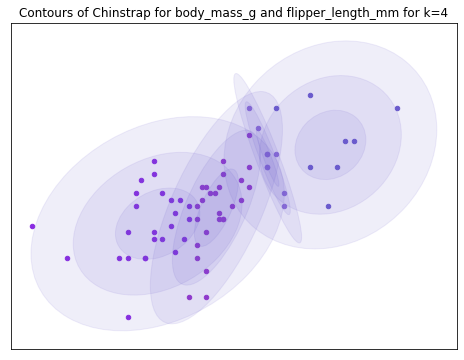

╒════════════╤═══════════════════════════════════╤═════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │            Component 1            │           Component 2           │            Component 3            │ Component 4                       │
╞════════════╪═══════════════════════════════════╪═════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │   [3422.75659501  192.28774843]   │  [4054.8782745   202.35526722]  │   [3760.2500164   194.75236652]   │ [4415.02115871  204.40270119]     │
├────────────┼───────────────────────────────────┼─────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ [[5.87822081e+04 3.72662260e+02]  │ [[4213.13883235 -262.16875468]  │ [[15995.4020641    505.52588723]  │ [[4.14860234e+04 1.59322224e+02]  │
│            │  [3.72662260e+02 3.01024534e+01]] │  [-262.

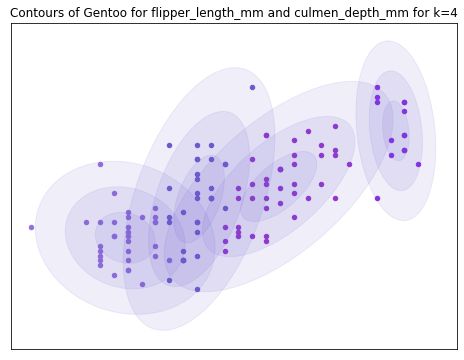

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │ Component 4                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [229.38698076  16.39775793] │ [209.81329796  14.16977747] │ [220.91113946  15.23738163] │ [215.1579028   14.97733507] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[ 0.92697733 -0.11515856]  │ [[ 4.69791725 -0.14840558]  │  [[7.61647802 1.28391132]   │ [[3.34180368 0.78792533]    │
│            │  [-0.11515856  0.3890557 ]] │  [-0.14840558  0.28229356]] │   [1.28391132 0.53238341]]  │  [0.78792533 0.831653  ]]   │
╘════════════╧═════════════════════════════╧═══════════

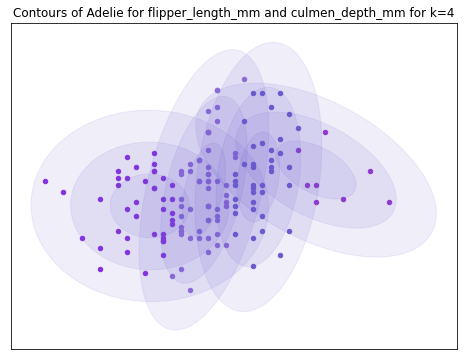

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │ Component 4                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [183.56129474  17.90015547] │ [189.55881166  18.35807729] │ [201.97036696  18.91822953] │ [195.5876164   18.72238327] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[19.24183902 -0.04251916]  │  [[5.73526459 1.39123139]   │ [[19.73183614 -1.84159306]  │ [[5.48265172 0.6884422 ]    │
│            │  [-0.04251916  0.82179774]] │   [1.39123139 1.76283803]]  │  [-1.84159306  0.67881103]] │  [0.6884422  1.62561578]]   │
╘════════════╧═════════════════════════════╧═══════════

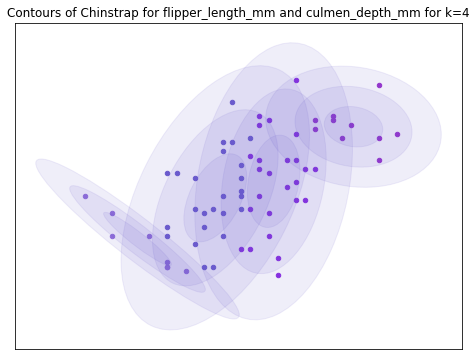

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │ Component 4                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [198.54643363  18.52283833] │ [183.74374357  17.22161718] │ [207.23006883  19.75311523] │ [192.20170606  18.15034075] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │  [[8.16326131 0.69156298]   │ [[13.60289373 -2.10031357]  │ [[10.12442927 -0.18948043]  │ [[11.6662058   1.60760757]  │
│            │   [0.69156298 1.08421453]]  │  [-2.10031357  0.36159828]] │  [-0.18948043  0.20741982]] │  [ 1.60760757  0.98600221]] │
╘════════════╧═════════════════════════════╧═══════════

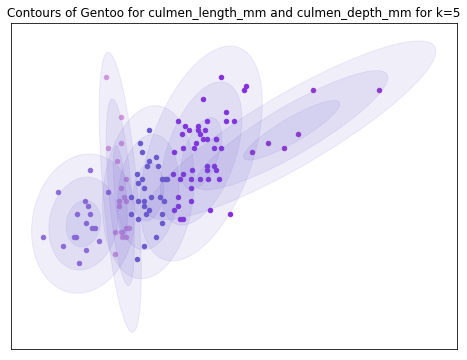

╒════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═════════════════════════════╕
│            │        Component 1        │        Component 2        │        Component 3        │        Component 4        │ Component 5                 │
╞════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═════════════════════════════╡
│    Mean    │ [49.69612699 15.57128808] │ [43.13059169 13.99350173] │ [54.72911958 16.09341093] │ [46.75033268 14.70037875] │ [45.1871536  14.69928032]   │
├────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┼─────────────────────────────┤
│ Covariance │ [[1.28645309 0.43368795]  │ [[0.92384814 0.05646562]  │ [[7.17378249 1.58844202]  │ [[0.72590028 0.08424611]  │ [[ 0.15245164 -0.23635542]  │
│            │  [0.43368795 0.64978759]] │  [0.05646562 0.

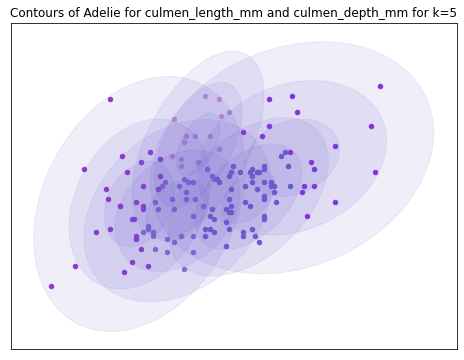

╒════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│            │        Component 1        │        Component 2        │        Component 3        │        Component 4        │ Component 5               │
╞════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│    Mean    │ [42.28586506 19.33616204] │ [37.4372931  17.74800993] │ [35.8381421  17.95009827] │ [40.43365254 18.16347376] │ [38.31575154 19.73105365] │
├────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│ Covariance │ [[3.98176265 0.49996549]  │ [[1.7386855  0.35243866]  │ [[2.22204845 0.52046548]  │ [[1.27180814 0.39821864]  │ [[0.86263494 0.45588344]  │
│            │  [0.49996549 1.34420427]] │  [0.35243866 0.82969921]] │

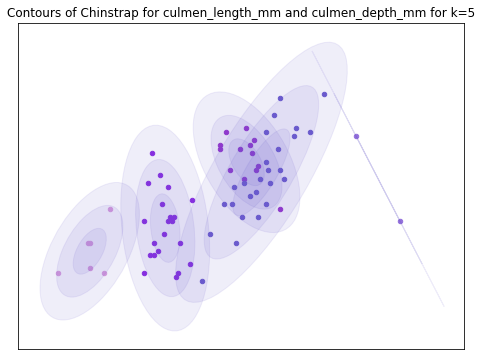

╒════════════╤═════════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│            │         Component 1         │        Component 2        │         Component 3         │        Component 4        │ Component 5               │
╞════════════╪═════════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│    Mean    │  [46.27130081 17.64271945]  │ [56.9000016  18.79999855] │  [50.33230526 19.18789454]  │ [51.07590021 18.95202228] │ [42.50126281 17.09900546] │
├────────────┼─────────────────────────────┼───────────────────────────┼─────────────────────────────┼───────────────────────────┼───────────────────────────┤
│ Covariance │ [[ 0.5474735  -0.12577061]  │  [[ 1.210001 -1.1     ]   │ [[ 0.7887114  -0.24256056]  │ [[2.04279638 1.13755617]  │ [[0.68457609 0.23952108]  │
│            │  [-0.12577061  0.6479953 ]] │  

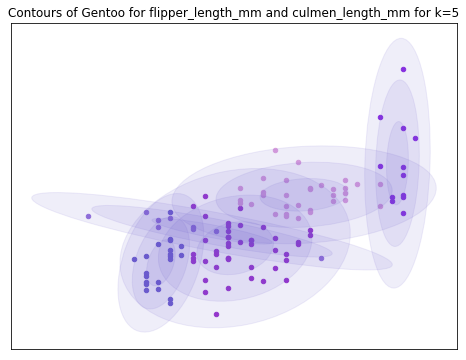

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │         Component 4         │ Component 5                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [229.50308143  52.40377503] │ [213.63593922  47.20520384] │ [215.61201793  45.91445742] │ [209.26261636  44.79569766] │ [221.51433304  49.98793867] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[ 0.87413075  0.32911212]  │ [[26.44259364 -4.36812977]  │ [[10.79449494  1.22216111]  │  [[1.50046986 0.81936646]   │ [[14.20694565  0.63747666]  │
│         

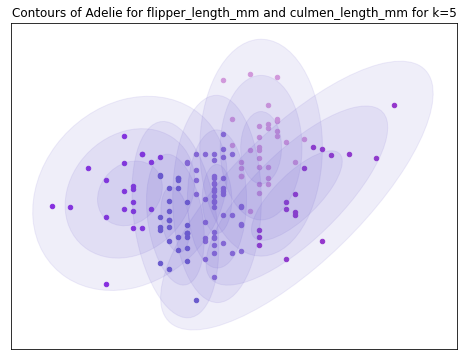

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │         Component 4         │ Component 5                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [180.67185755  38.65315374] │ [190.34324117  38.31244319] │ [199.20954792  38.5191728 ] │ [185.71963085  37.04094155] │ [195.23882009  41.46080689] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[12.94902355  1.3383191 ]  │ [[ 2.69451268 -0.03639811]  │ [[25.44359528 10.55232988]  │ [[ 2.57795408 -0.89793033]  │ [[5.15093121 0.01068598]    │
│         

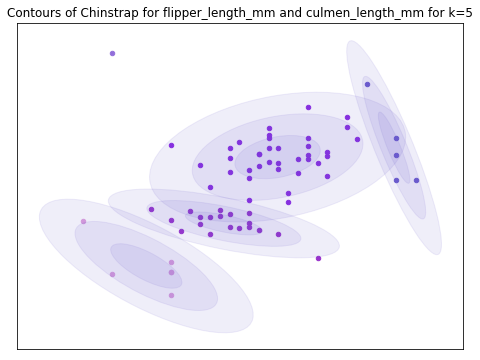

╒════════════╤═════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │            Component 2            │         Component 3         │         Component 4         │ Component 5                 │
╞════════════╪═════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [197.91079036  50.64499116] │            [181.  58.]            │ [192.42441773  45.94800083] │ [209.80467242  51.31319799] │ [184.5043237   42.93557386] │
├────────────┼─────────────────────────────┼───────────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[18.99137701  2.04693921]  │ [[1.00000000e-06 5.08909947e-26]  │ [[15.46400384 -2.08635426]  │ [[ 2.60397459 -3.672646  ]  │ [[13

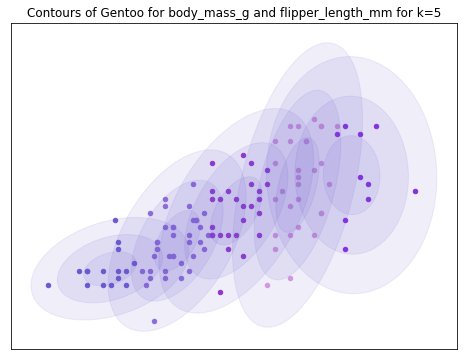

╒════════════╤═════════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│            │             Component 1             │            Component 2            │            Component 3            │            Component 4            │ Component 5                       │
╞════════════╪═════════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    Mean    │    [5894.01505956  223.24421985]    │   [4775.98440187  214.16758184]   │   [5155.01998266  218.29560882]   │   [4345.59796153  210.26980858]   │ [5547.38259376  221.88266723]     │
├────────────┼─────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┤
│ Covariance │ 

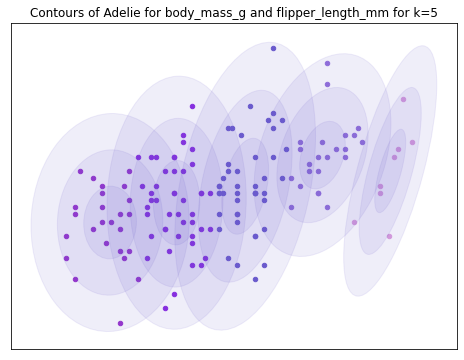

╒════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════════╕
│            │            Component 1            │            Component 2            │            Component 3            │            Component 4            │ Component 5                     │
╞════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════════╡
│    Mean    │   [3465.37030227  188.62221313]   │   [4277.37793555  195.20987339]   │    [3095.101491   185.8825857]    │   [3847.10127308  190.90262666]   │ [4654.38596426  193.01521094]   │
├────────────┼───────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┼─────────────────────────────────┤
│ Covariance │ [[16686.57093444    

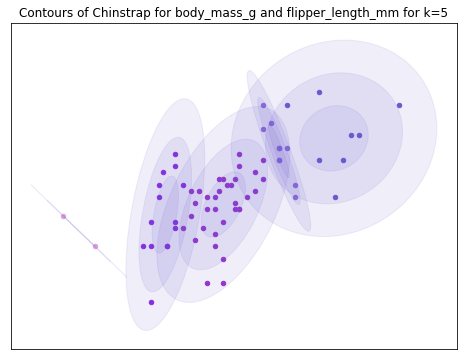

╒════════════╤═════════════════════════════════╤═════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════════╕
│            │           Component 1           │           Component 2           │            Component 3            │            Component 4            │ Component 5                     │
╞════════════╪═════════════════════════════════╪═════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════════╡
│    Mean    │  [3340.55915116  192.16452624]  │  [4051.53022497  202.49362977]  │   [3703.47172343  193.80327791]   │   [4395.81557567  204.53410031]   │ [2799.99999999  189.5       ]   │
├────────────┼─────────────────────────────────┼─────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────┼─────────────────────────────────┤
│ Covariance │ [[6758.20320959  248.10982646]  │ [[4393

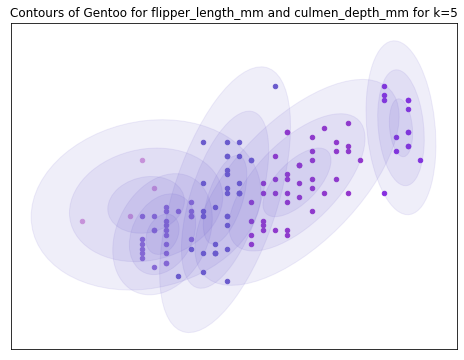

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │         Component 4         │ Component 5                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [229.38814558  16.39802617] │ [209.68276323  14.10890672] │ [220.79292958  15.22368332] │ [214.85115255  14.85123886] │ [208.32424316  14.7401817 ] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[ 0.92623128 -0.11571847]  │  [[1.87996957 0.15530213]   │  [[7.91583363 1.32862282]   │  [[3.25071538 0.94556048]   │ [[10.02640212  0.27077392]  │
│         

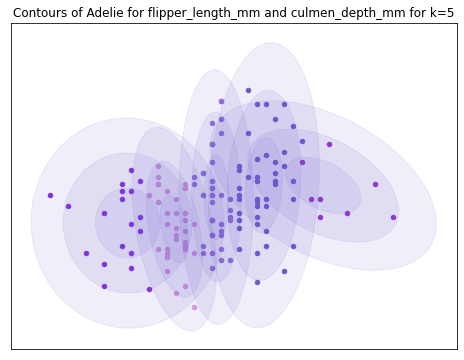

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │         Component 4         │ Component 5                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [180.63931189  17.82889879] │ [190.47937584  18.54455161] │ [202.31286234  18.86315212] │ [195.75421826  18.86902229] │ [185.82335485  17.65827122] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │ [[12.70908666 -0.03876087]  │ [[ 1.88905813 -0.07310767]  │ [[17.48088557 -1.46815036]  │  [[4.1868499  0.33509278]   │ [[ 2.42666324 -0.58402083]  │
│         

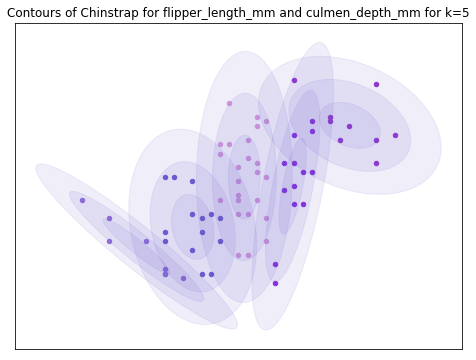

╒════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│            │         Component 1         │         Component 2         │         Component 3         │         Component 4         │ Component 5                 │
╞════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│    Mean    │ [200.90798768  18.49239566] │ [183.95307702  17.18686343] │ [207.10923711  19.81140112] │ [190.04439285  17.61199882] │ [195.65732441  18.69303669] │
├────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┼─────────────────────────────┤
│ Covariance │  [[2.17990992 1.00687668]   │ [[13.34251816 -2.06809474]  │ [[10.94422077 -0.53447665]  │ [[ 5.35458321 -0.31140171]  │ [[3.01851433 0.03458356]    │
│         

In [13]:
[fitGMMandPlot(pd.concat([ping[feature1][ping.species == spc],
                          ping[feature2][ping.species == spc]], 
                         axis=1, sort=False), numComp, feature1, feature2, 
               spc) for numComp in range(2,6) for feature1,feature2 in features for spc in species]
print('')

In [48]:
def plotAICandBIC(dataset, title):
  n_comp = np.arange(2,6)
  models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(dataset) for n in n_comp]

  plt.plot(n_comp, [model.aic(dataset) for model in models], label="AIC", color='mediumpurple')
  plt.plot(n_comp, [model.bic(dataset) for model in models], label="BIC", color='slateblue')
  plt.title(title)
  plt.legend(loc='best')
  plt.show()

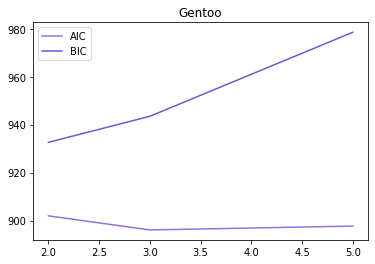

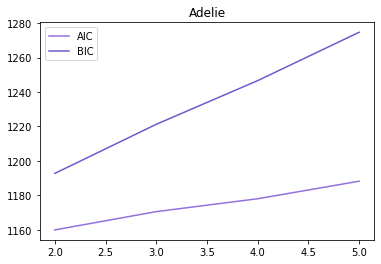

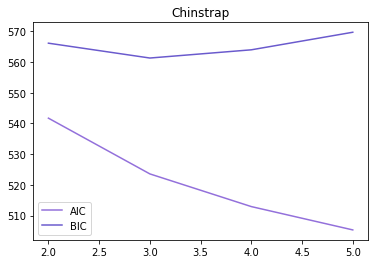

In [49]:
[plotAICandBIC(pd.concat([ping["culmen_length_mm"][ping.species == spc],
                          ping["culmen_depth_mm"][ping.species == spc]], 
                         axis=1, sort=False), spc) for spc in species]
print('')

#  <font color=slateblue>Problem 9</font> #

Downloading DataBase

In [50]:
totalData = datasets.make_moons(n_samples=500, noise=.11)
noisyMoonsData, noisyMoonsLabels = totalData[0], totalData[1]

Plotting Data Based on Its Classes

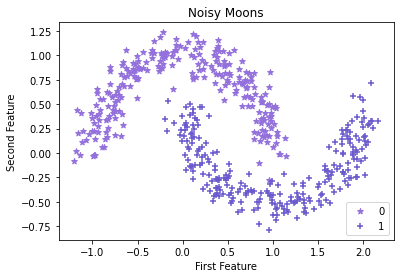

In [51]:
zerosData = np.array([noisyMoonsData[i,0:2] for i in range(len(noisyMoonsData)) if noisyMoonsLabels[i]==0])
onesData = np.array([noisyMoonsData[i,0:2] for i in range(len(noisyMoonsData)) if noisyMoonsLabels[i]==1])


plt.scatter(zerosData[:,0], zerosData[:,1],
                marker='*', color='mediumpurple', label=0)
plt.scatter(onesData[:,0], onesData[:,1],
                marker='+', color='slateblue', label=1)

plt.title('Noisy Moons')
plt.xlabel('First Feature')
plt.ylabel('Second Feature')
plt.legend(loc="lower right")
plt.show()

###  <font color=slateblue>Part A</font> ###

For Two Classes without GMM





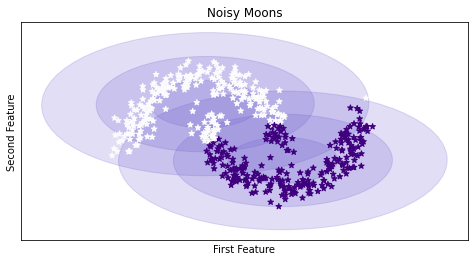

In [52]:
def calcLikelihood(data, mean, sigma):
    if LA.det(sigma) == 0:
      invOfMt = LA.pinv(sigma)
      detOfMat = self.calcDetMat(sigma)
    else:
      invOfMt = LA.inv(sigma)
      detOfMat = LA.det(sigma)

    return np.exp((-1/2) * np.diag((((data-mean)) @ (invOfMt) 
                  @ (data-mean).T))) * ((detOfMat)**(-0.5) * (2*np.pi)**(-1/2))

def twoClasses(data, labels):
  priors = np.array([np.mean(labels==label) for label in range(2)])
  mu = [data[labels == i].mean(axis=0) for i in range(2)]
  sigma = [np.cov(data[labels == i].T) for i in range(2)]

  post = np.array([calcLikelihood(data, mu[i], sigma[i]).dot(priors[i]) for i in range(2)])

  return np.argmax(post, axis=0), mu, sigma


def plotContours(mid, cov, ax=None):
    ax = ax or plt.gca()
    
    if cov.shape == (2, 2):
        U, S, Vt = LA.svd(cov)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(S)
    else:
        angle = 0
        width, height = 2 * np.sqrt(cov)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(mid, nsig * width, nsig * height, 
                             angle, alpha=0.2, color='slateblue'))

def plotPredAndData(data, labels):
  predLabels, mu, sigma = twoClasses(data, labels)

  fig = plt.figure(figsize=(8,4))
  for i in range(2):
      plotContours(mu[i], sigma[i])

  plt.scatter(data[:, 0], data[:, 1], c=predLabels, cmap='Purples', zorder=2, marker='*')

  plt.title('Noisy Moons')
  plt.xlabel('First Feature')
  plt.ylabel('Second Feature')
  plt.xticks(())
  plt.yticks(())
  plt.show()



plotPredAndData(noisyMoonsData, noisyMoonsLabels)

###  <font color=slateblue>Part B</font> ###

Gaussian Mixture Model

In [53]:
class GMM():
  def __init__(self, _numIter, _numPDF, _varSmoothing):
    self.numPDF = _numPDF
    self.numIter = _numIter
    self.varSmoothing = _varSmoothing

  def calcDetMat(self, mat):
    return LA.det(mat+self.varSmoothing*np.eye(len(mat)))

  def calcLikelihood(self, data, mean, sigma):
    if LA.det(sigma) == 0:
      invOfMt = LA.pinv(sigma)
      detOfMat = self.calcDetMat(sigma)
    else:
      invOfMt = LA.inv(sigma)
      detOfMat = LA.det(sigma)

    return np.exp((-1/2) * np.diag((((data-mean)) @ (invOfMt) 
                  @ (data-mean).T))) * ((detOfMat)**(-0.5) * (2*np.pi)**(-self.numPDF/2))

  def updatePj(self, data):
    likelihood = np.zeros((self.row, self.numPDF))

    for i in range(self.numPDF):
      likelihood[:,i] = self.calcLikelihood(data, self.mu[i], self.sigma[i])

    num = likelihood * self.alpha
    denum = num.sum(axis=1)[:, np.newaxis]
    return (num/denum), likelihood
      

  def EStep(self, data):
    self.pj, _ = self.updatePj(data)
    self.alpha = self.pj.mean(axis=0)

  def MStep(self, data):
    for i in range(self.numPDF):
      pj = self.pj[:, [i]]
      self.mu[i] = ((data * pj).sum(axis=0))/(pj.sum())
      self.sigma[i] = np.cov(data.T, aweights=(pj/pj.sum()).flatten(), bias=True)

  def fit(self, data):
    self.row, self.clm = data.shape

    self.alpha = np.full(shape=self.numPDF, fill_value=1/self.numPDF)
    self.pj = np.full(shape=data.shape, fill_value=1/self.numPDF)

    rowInds = random.sample(range(0, self.row), self.numPDF)
    self.mu = [data[i, :] for i in rowInds]
    self.sigma = [np.cov(data.T) for i in range(self.numPDF)]

    for iter in range(self.numIter):
      self.EStep(data)
      self.MStep(data)

  def predict(self, data):
    pj, likelihood = self.updatePj(data)
    return np.argmax(pj, axis=1), likelihood


  def plotContours(self, mid, cov, ax=None):
    ax = ax or plt.gca()
    
    if cov.shape == (2, 2):
        U, S, Vt = LA.svd(cov)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(S)
    else:
        angle = 0
        width, height = 2 * np.sqrt(cov)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(mid, nsig * width, nsig * height, 
                             angle, alpha=0.2, color='slateblue'))

  def plotPredAndData(self, data):
    fig = plt.figure(figsize=(8,4))
    
    for i in range(self.numPDF):
        self.plotContours(self.mu[i], self.sigma[i])

    predLabels, _ = self.predict(data)
    plt.scatter(data[:, 0], data[:, 1], c=predLabels, cmap='Purples', zorder=self.numPDF, marker='*')

    plt.title('Noisy Moons')
    plt.xlabel('First Feature')
    plt.ylabel('Second Feature')
    plt.xticks(())
    plt.yticks(())
    plt.show()

  def AIC(self, data):
    _, likelihood = self.predict(data)
    return 2 * (self.numPDF - np.log((likelihood.sum(axis=1).sum())))

  def BIC(self, data):
     _, likelihood = self.predict(data)
     return (self.numPDF * np.log(len(data)) - 2 * np.log((likelihood.sum(axis=1).sum())))



Employing GMM for Various Values

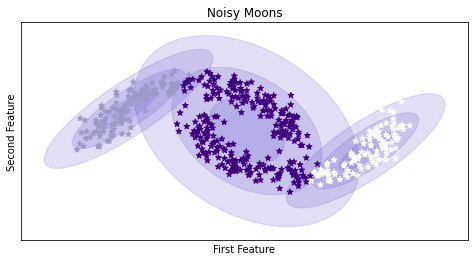

In [107]:
myGMM = GMM(2000, 3, 1e-9)
myGMM.fit(noisyMoonsData)
myGMM.plotPredAndData(noisyMoonsData)


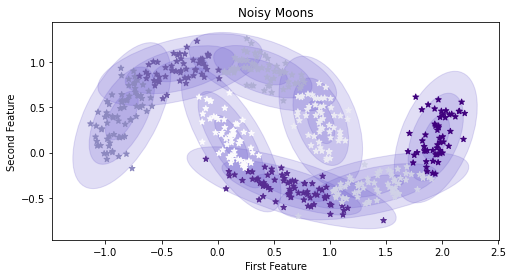

In [ ]:
myGMM = GMM(1000, 8, 1e-6)
myGMM.fit(noisyMoonsData)
myGMM.plotPredAndData(noisyMoonsData)

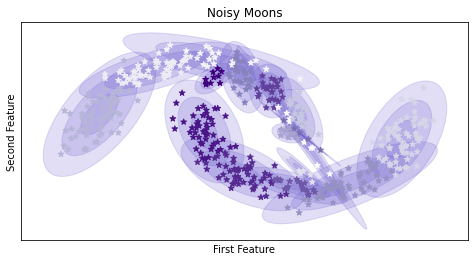

In [71]:
myGMM = GMM(2000, 16, 1e-6)
myGMM.fit(noisyMoonsData)
myGMM.plotPredAndData(noisyMoonsData)

Plot AIC and BIC 

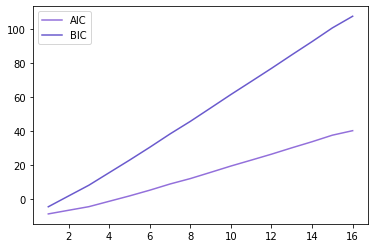

In [108]:
numComp = np.arange(1,17)
AICs, BICs = [], []

for i in numComp:
  model = GMM(800, i, 1e-5)
  model.fit(noisyMoonsData)
  AICs.append(model.AIC(noisyMoonsData))
  BICs.append(model.BIC(noisyMoonsData))

plt.plot(numComp, AICs, label="AIC", color='mediumpurple')
plt.plot(numComp, BICs, label="BIC", color='slateblue')
plt.legend(loc='best')
plt.show()


Employing SKLearn's GMM

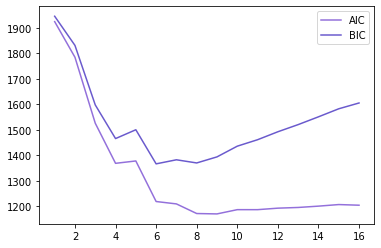

In [109]:
n_comp = np.arange(1,17)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(noisyMoonsData) for n in n_comp]

plt.plot(n_comp, [model.aic(noisyMoonsData) for model in models], label="AIC", color='mediumpurple')
plt.plot(n_comp, [model.bic(noisyMoonsData) for model in models], label="BIC", color='slateblue')
plt.legend(loc='best')
plt.show()